In [1]:
import cv2
import numpy as np
import os
import random
import tqdm

In [ ]:
#Pre processing for optic disk removal
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from scipy.ndimage import binary_fill_holes

def detect_and_remove_optic_disc(image_path, margin_size=10, display_results=True):
    """
    Complete pipeline to detect and remove (blacken) optic disc from fundus images

    Parameters:
    - image_path: Path to the fundus image
    - margin_size: Extra margin to add around optic disc (in pixels)
    - display_results: Whether to display visualization of results

    Returns:
    - Dictionary containing processed images and detection info
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    # Store original for display
    orig_img = img.copy()
    img = cv2.resize(img, (512, 512))

    # STEP 2: Determine image type (gray or color)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    mean_saturation = np.mean(saturation)

    if mean_saturation < 50:
        image_type = "GRAY"
    else:
        image_type = "COLOR"

    # STEP 3: Channel selection and enhancement based on image type
    if image_type == "GRAY":
        # Use multichannel approach for gray images
        b, g, r = cv2.split(img)
        combined = cv2.addWeighted(cv2.addWeighted(r, 0.4, g, 0.4, 0), 0.8, b, 0.2, 0)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(combined)

        # Apply bilateral filtering for gray images
        enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

        # For gray images, also apply additional contrast enhancement
        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)

    else:  # COLOR images
        # Use green-red combination for color images
        _, g, r = cv2.split(img)
        combined = cv2.addWeighted(r, 0.6, g, 0.4, 0)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(combined)

    # STEP 4: Optic disc localization
    # Apply Gaussian blur for localization
    blurred = cv2.GaussianBlur(enhanced, (31, 31), 0)

    # Create anatomical prior (higher weights for regions where OD typically appears)
    h, w = enhanced.shape
    prior_map = np.ones((h, w), dtype=np.float32)

    # For gray images, emphasize upper left quadrant where OD often appears
    if image_type == "GRAY":
        # Higher weight for upper left quadrant
        prior_map[:h//2, :w//2] *= 2.0

        # Apply prior to blurred image
        blurred = blurred * prior_map

    # Find brightest region (likely optic disc center)
    od_y, od_x = np.unravel_index(np.argmax(blurred), blurred.shape)

    # STEP 5: Determine appropriate optic disc radius
    if image_type == "GRAY":
        od_radius = int(img.shape[0] * 0.07)  # Smaller radius for gray images
    else:
        od_radius = int(img.shape[0] * 0.08)  # Larger radius for color images

    # STEP 6: Create initial circular mask
    od_mask = np.zeros_like(enhanced)
    cv2.circle(od_mask, (od_x, od_y), od_radius, 255, -1)

    # Apply morphological operations to smooth mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    od_mask = cv2.morphologyEx(od_mask, cv2.MORPH_CLOSE, kernel)
    od_mask = binary_fill_holes(od_mask).astype(np.uint8) * 255

    # STEP 7: Create expanded mask with safety margin
    # Create structuring element for dilation
    margin_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (margin_size*2+1, margin_size*2+1))

    # Dilate the mask to create extra margin
    expanded_mask = cv2.dilate(od_mask, margin_kernel, iterations=1)

    # STEP 8: Resize masks to match original image size
    orig_h, orig_w = orig_img.shape[:2]
    od_mask_resized = cv2.resize(od_mask, (orig_w, orig_h))
    expanded_mask_resized = cv2.resize(expanded_mask, (orig_w, orig_h))

    # STEP 9: Remove (blacken) optic disc in original image
    # Invert the expanded mask
    removal_mask = cv2.bitwise_not(expanded_mask_resized)

    # Apply mask to original image
    result_img = cv2.bitwise_and(orig_img, orig_img, mask=removal_mask)

    # Prepare overlay image for visualization
    overlay_img = orig_img.copy()
    overlay_mask = np.zeros_like(orig_img)
    overlay_mask[:, :, 0] = od_mask_resized  # Red channel only

    # Add overlay to original image
    alpha = 0.4
    overlay_result = cv2.addWeighted(overlay_img, 1, overlay_mask, alpha, 0)

    # Display results if requested
    if display_results:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(od_mask_resized, cmap='gray')
        plt.title('Optic Disc Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(expanded_mask_resized, cmap='gray')
        plt.title(f'Expanded Mask (+{margin_size}px)')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title('Overlay of Mask on Original')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title('Image with OD Removed')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Return results
    results = {
        'original_image': orig_img,
        'od_mask': od_mask_resized,
        'expanded_mask': expanded_mask_resized,
        'overlay_image': overlay_result,
        'od_removed_image': result_img,
        'detection_info': {
            'image_type': image_type,
            'od_center': (od_x * orig_w // 512, od_y * orig_h // 512),
            'od_radius': od_radius * orig_w // 512,
            'margin_size': margin_size
        }
    }

    return results

def batch_process_images(image_folder, output_folder, margin_size=10):
    """
    Process multiple images and save results

    Parameters:
    - image_folder: Path to folder containing retinal images
    - output_folder: Path to save processed images
    - margin_size: Extra margin to add around optic disc (in pixels)
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'masks'))
        os.makedirs(os.path.join(output_folder, 'expanded_masks'))
        os.makedirs(os.path.join(output_folder, 'removed_od'))

    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]

    for i, filename in enumerate(image_files):
        #print(f"Processing image {i+1}/{len(image_files)}: {filename}")

        # Full path to image
        image_path = os.path.join(image_folder, filename)

        try:
            # Process image
            results = detect_and_remove_optic_disc(image_path, margin_size, display_results=False)

            if results is None:
                print(f"  Failed to process {filename}")
                continue

            # Save results
            base_name = os.path.splitext(filename)[0]

            # Save mask
            cv2.imwrite(os.path.join(output_folder, 'masks', f"{base_name}_od_mask.png"),
                       results['od_mask'])

            # Save expanded mask
            cv2.imwrite(os.path.join(output_folder, 'expanded_masks', f"{base_name}_expanded_mask.png"),
                       results['expanded_mask'])

            # Save image with OD removed
            cv2.imwrite(os.path.join(output_folder, 'removed_od', f"{base_name}_od_removed.png"),
                       results['od_removed_image'])

        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")

    print(f"Processing complete. Results saved to {output_folder}")

# Example usage
if __name__ == "__main__":
    # Single image processing
    #image_path = "/content/drive/MyDrive/Dataset_1/train/0/00cc2b75cddd-600.jpg"  # Change to your image path
    #results = detect_and_remove_optic_disc(image_path, margin_size=25)


    # To process an entire folder of images, uncomment these lines: DR folder
    image_folder = "/kaggle/input/base-dataset-small-batch/Training_Images_Small_batch/DR"
    output_folder = "/kaggle/working/DR_OD_Removed_test"
    batch_process_images(image_folder, output_folder, margin_size=25)

    # To process an entire folder of images, uncomment these lines: No-DR folder
    image_folder1 = "/kaggle/input/base-dataset-small-batch/Training_Images_Small_batch/No_DR"
    output_folder1 = "/kaggle/working/No_DR_OD_Removed_test"
    batch_process_images(image_folder1, output_folder1, margin_size=25)

'''

In [2]:
#Optic disk removal with progress bar
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm
import random

def detect_and_remove_optic_disc(image_path, margin_size=10, display_results=True):
    """
    Complete pipeline to detect and remove (blacken) optic disc from fundus images

    Parameters:
    - image_path: Path to the fundus image
    - margin_size: Extra margin to add around optic disc (in pixels)
    - display_results: Whether to display visualization of results

    Returns:
    - Dictionary containing processed images and detection info
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    # Store original for display
    orig_img = img.copy()
    img = cv2.resize(img, (512, 512))

    # STEP 2: Determine image type (gray or color)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    mean_saturation = np.mean(saturation)

    if mean_saturation < 50:
        image_type = "GRAY"
    else:
        image_type = "COLOR"

    # STEP 3: Channel selection and enhancement based on image type
    if image_type == "GRAY":
        # Use multichannel approach for gray images
        b, g, r = cv2.split(img)
        combined = cv2.addWeighted(cv2.addWeighted(r, 0.4, g, 0.4, 0), 0.8, b, 0.2, 0)
        clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(combined)

        # Apply bilateral filtering for gray images
        enhanced = cv2.bilateralFilter(enhanced, 9, 75, 75)

        # For gray images, also apply additional contrast enhancement
        enhanced = cv2.normalize(enhanced, None, 0, 255, cv2.NORM_MINMAX)

    else:  # COLOR images
        # Use green-red combination for color images
        _, g, r = cv2.split(img)
        combined = cv2.addWeighted(r, 0.6, g, 0.4, 0)
        clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(combined)

    # STEP 4: Optic disc localization
    # Apply Gaussian blur for localization
    blurred = cv2.GaussianBlur(enhanced, (31, 31), 0)

    # Create anatomical prior (higher weights for regions where OD typically appears)
    h, w = enhanced.shape
    prior_map = np.ones((h, w), dtype=np.float32)

    # For gray images, emphasize upper left quadrant where OD often appears
    if image_type == "GRAY":
        # Higher weight for upper left quadrant
        prior_map[:h//2, :w//2] *= 2.0

        # Apply prior to blurred image
        blurred = blurred * prior_map

    # Find brightest region (likely optic disc center)
    od_y, od_x = np.unravel_index(np.argmax(blurred), blurred.shape)

    # STEP 5: Determine appropriate optic disc radius
    if image_type == "GRAY":
        od_radius = int(img.shape[0] * 0.07)  # Smaller radius for gray images
    else:
        od_radius = int(img.shape[0] * 0.08)  # Larger radius for color images

    # STEP 6: Create initial circular mask
    od_mask = np.zeros_like(enhanced)
    cv2.circle(od_mask, (od_x, od_y), od_radius, 255, -1)

    # Apply morphological operations to smooth mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    od_mask = cv2.morphologyEx(od_mask, cv2.MORPH_CLOSE, kernel)
    od_mask = binary_fill_holes(od_mask).astype(np.uint8) * 255

    # STEP 7: Create expanded mask with safety margin
    # Create structuring element for dilation
    margin_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (margin_size*2+1, margin_size*2+1))

    # Dilate the mask to create extra margin
    expanded_mask = cv2.dilate(od_mask, margin_kernel, iterations=1)

    # STEP 8: Resize masks to match original image size
    orig_h, orig_w = orig_img.shape[:2]
    od_mask_resized = cv2.resize(od_mask, (orig_w, orig_h))
    expanded_mask_resized = cv2.resize(expanded_mask, (orig_w, orig_h))

    # STEP 9: Remove (blacken) optic disc in original image
    # Invert the expanded mask
    removal_mask = cv2.bitwise_not(expanded_mask_resized)

    # Apply mask to original image
    result_img = cv2.bitwise_and(orig_img, orig_img, mask=removal_mask)

    # Prepare overlay image for visualization
    overlay_img = orig_img.copy()
    overlay_mask = np.zeros_like(orig_img)
    overlay_mask[:, :, 0] = od_mask_resized  # Red channel only

    # Add overlay to original image
    alpha = 0.4
    overlay_result = cv2.addWeighted(overlay_img, 1, overlay_mask, alpha, 0)

    # Display results if requested
    if display_results:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(od_mask_resized, cmap='gray')
        plt.title('Optic Disc Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(expanded_mask_resized, cmap='gray')
        plt.title(f'Expanded Mask (+{margin_size}px)')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title('Overlay of Mask on Original')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title('Image with OD Removed')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Return results
    results = {
        'original_image': orig_img,
        'od_mask': od_mask_resized,
        'expanded_mask': expanded_mask_resized,
        'overlay_image': overlay_result,
        'od_removed_image': result_img,
        'detection_info': {
            'image_type': image_type,
            'od_center': (od_x * orig_w // 512, od_y * orig_h // 512),
            'od_radius': od_radius * orig_w // 512,
            'margin_size': margin_size
        }
    }

    return results

def batch_process_images(image_folder, output_folder, margin_size=10, sample_limit=None):
    """
    Process multiple images and save results

    Parameters:
    - image_folder: Path to folder containing retinal images
    - output_folder: Path to save processed images
    - margin_size: Extra margin to add around optic disc (in pixels)
    - sample_limit: Maximum number of samples to process (None for all)
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'masks'))
        os.makedirs(os.path.join(output_folder, 'expanded_masks'))
        os.makedirs(os.path.join(output_folder, 'removed_od'))

    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    
    # Apply sample limit if specified
    if sample_limit is not None and sample_limit < len(image_files):
        image_files = random.sample(image_files, sample_limit)
        print(f"Randomly selected {sample_limit} images for processing")

    # Process images with progress bar
    for i, filename in tqdm(enumerate(image_files), total=len(image_files), 
                           desc="Processing images", unit="image"):
        # Full path to image
        image_path = os.path.join(image_folder, filename)

        try:
            # Process image
            results = detect_and_remove_optic_disc(image_path, margin_size, display_results=False)

            if results is None:
                print(f"  Failed to process {filename}")
                continue

            # Save results
            base_name = os.path.splitext(filename)[0]

            # Save mask
            cv2.imwrite(os.path.join(output_folder, 'masks', f"{base_name}_od_mask.png"),
                       results['od_mask'])

            # Save expanded mask
            cv2.imwrite(os.path.join(output_folder, 'expanded_masks', f"{base_name}_expanded_mask.png"),
                       results['expanded_mask'])

            # Save image with OD removed
            cv2.imwrite(os.path.join(output_folder, 'removed_od', f"{base_name}_od_removed.png"),
                       results['od_removed_image'])

        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")

    print(f"Processing complete. Results saved to {output_folder}")

# Example usage
if __name__ == "__main__":
    # Single image processing
    #image_path = "/content/drive/MyDrive/Dataset_1/train/0/00cc2b75cddd-600.jpg"  # Change to your image path
    #results = detect_and_remove_optic_disc(image_path, margin_size=25)

    # To process an entire folder of images with sample limit: DR folder
    image_folder = "/kaggle/input/aptos-augumented-dr-12/Augumented_DR_Images"
    output_folder = "/kaggle/working/DR_OD_Removed_1369"
    batch_process_images(image_folder, output_folder, margin_size=25, sample_limit=3000)  # Process only 1000 samples

    # To process an entire folder of images with sample limit: No-DR folder
    image_folder1 = "/kaggle/input/aptos-augumented-no-dr/No_DR_Augumented_Image"
    output_folder1 = "/kaggle/working/No_DR_OD_Removed_1369"
    batch_process_images(image_folder1, output_folder1, margin_size=25, sample_limit=3000)  # Process only 1000 samples

Processing images: 100%|██████████| 1369/1369 [09:40<00:00,  2.36image/s]


Processing complete. Results saved to /kaggle/working/DR_OD_Removed_1369
Randomly selected 1369 images for processing


Processing images: 100%|██████████| 1369/1369 [04:34<00:00,  4.99image/s]

Processing complete. Results saved to /kaggle/working/No_DR_OD_Removed_1369


In [ ]:
#Follow up code to remove macula after od removal
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from scipy.ndimage import binary_fill_holes

def detect_and_remove_macula(image_path, margin_size=10, display_results=True):
    """
    Function to detect and remove (blacken) macula from fundus images
    that already have the optic disc removed.

    Parameters:
    - image_path: Path to the fundus image with optic disc removed
    - margin_size: Extra margin to add around macula (in pixels)
    - display_results: Whether to display visualization of results

    Returns:
    - Dictionary containing processed images and detection info
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    # Store original for display
    orig_img = img.copy()
    img = cv2.resize(img, (512, 512))

    # STEP 2: Determine image type (gray or color)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    mean_saturation = np.mean(saturation)

    if mean_saturation < 50:
        image_type = "GRAY"
    else:
        image_type = "COLOR"

    # STEP 3: Channel selection and enhancement for macula detection
    if image_type == "GRAY":
        # Use green channel for macula detection in gray images
        _, g, _ = cv2.split(img)
        enhanced = g.copy()
    else:  # COLOR images
        # Use mostly green channel for macula detection in color images
        _, g, r = cv2.split(img)
        # The macula is often well visible in the green channel
        enhanced = g.copy()

    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(enhanced)

    # STEP 4: Macula localization
    # The macula is typically darker than surrounding areas
    # We'll invert the image to make it appear as a bright spot
    inverted = cv2.bitwise_not(enhanced)

    # Apply Gaussian blur for localization
    blurred = cv2.GaussianBlur(inverted, (21, 21), 0)

    # Create anatomical prior (higher weights for central region where macula typically appears)
    h, w = enhanced.shape
    
    # Since OD is removed, we'll focus on finding the macula in the central region
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Higher weight for central region
    weight = np.exp(-dist_from_center / (h/5))
    blurred = blurred * weight

    # Find darkest region (now brightest in inverted image)
    macula_y, macula_x = np.unravel_index(np.argmax(blurred), blurred.shape)

    # STEP 5: Determine appropriate macula radius
    macula_radius = int(img.shape[0] * 0.06)  # Adjust as needed

    # STEP 6: Create initial circular mask
    macula_mask = np.zeros_like(enhanced)
    cv2.circle(macula_mask, (macula_x, macula_y), macula_radius, 255, -1)

    # Apply morphological operations to smooth mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    macula_mask = cv2.morphologyEx(macula_mask, cv2.MORPH_CLOSE, kernel)
    macula_mask = binary_fill_holes(macula_mask).astype(np.uint8) * 255

    # STEP 7: Create expanded mask with safety margin
    # Create structuring element for dilation
    margin_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (margin_size*2+1, margin_size*2+1))

    # Dilate the mask to create extra margin
    expanded_mask = cv2.dilate(macula_mask, margin_kernel, iterations=1)

    # STEP 8: Resize masks to match original image size
    orig_h, orig_w = orig_img.shape[:2]
    macula_mask_resized = cv2.resize(macula_mask, (orig_w, orig_h))
    expanded_mask_resized = cv2.resize(expanded_mask, (orig_w, orig_h))

    # STEP 9: Remove (blacken) macula in original image
    # Invert the expanded mask
    removal_mask = cv2.bitwise_not(expanded_mask_resized)

    # Apply mask to original image
    result_img = cv2.bitwise_and(orig_img, orig_img, mask=removal_mask)

    # Prepare overlay image for visualization
    overlay_img = orig_img.copy()
    overlay_mask = np.zeros_like(orig_img)
    overlay_mask[:, :, 2] = macula_mask_resized  # Blue channel for macula

    # Add overlay to original image
    alpha = 0.4
    overlay_result = cv2.addWeighted(overlay_img, 1, overlay_mask, alpha, 0)

    # Display results if requested
    if display_results:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image (OD removed)')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(macula_mask_resized, cmap='gray')
        plt.title('Macula Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(expanded_mask_resized, cmap='gray')
        plt.title(f'Expanded Mask (+{margin_size}px)')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title('Overlay of Mask on Original')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title('Image with Macula Removed')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Return results
    results = {
        'original_image': orig_img,
        'macula_mask': macula_mask_resized,
        'expanded_mask': expanded_mask_resized,
        'overlay_image': overlay_result,
        'macula_removed_image': result_img,
        'detection_info': {
            'image_type': image_type,
            'macula_center': (macula_x * orig_w // 512, macula_y * orig_h // 512),
            'macula_radius': macula_radius * orig_w // 512,
            'margin_size': margin_size
        }
    }

    return results

def batch_process_images(image_folder, output_folder, margin_size=10):
    """
    Process multiple images and save results
    
    Parameters:
    - image_folder: Path to folder containing images with optic disc already removed
    - output_folder: Path to save processed images
    - margin_size: Extra margin to add around macula (in pixels)
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'masks'))
        os.makedirs(os.path.join(output_folder, 'expanded_masks'))
        os.makedirs(os.path.join(output_folder, 'removed_macula'))
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    
    for i, filename in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")
        
        # Full path to image
        image_path = os.path.join(image_folder, filename)
        
        try:
            # Process image
            results = detect_and_remove_macula(image_path, margin_size, display_results=False)
            
            if results is None:
                print(f"  Failed to process {filename}")
                continue
                
            # Save results
            base_name = os.path.splitext(filename)[0]
            
            # Save mask
            cv2.imwrite(os.path.join(output_folder, 'masks', f"{base_name}_macula_mask.png"),
                       results['macula_mask'])
            
            # Save expanded mask
            cv2.imwrite(os.path.join(output_folder, 'expanded_masks', f"{base_name}_expanded_mask.png"),
                       results['expanded_mask'])
            
            # Save image with macula removed
            cv2.imwrite(os.path.join(output_folder, 'removed_macula', f"{base_name}_macula_removed.png"),
                       results['macula_removed_image'])
            
        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")
    
    print(f"Processing complete. Results saved to {output_folder}")

# Example usage - process the folders with images that already have OD removed
if __name__ == "__main__":
    # For DR dataset
    image_folder_dr = "/kaggle/working/DR_OD_Removed_test/removed_od"  # Folder with OD-removed DR images
    output_folder_dr = "/kaggle/working/DR_Both_Removed10"  # Output folder for DR images with both removed
    batch_process_images(image_folder_dr, output_folder_dr, margin_size=25)
    
    # For No_DR dataset
    image_folder_no_dr = "/kaggle/working/No_DR_OD_Removed_test/removed_od"  # Folder with OD-removed No_DR images
    output_folder_no_dr = "/kaggle/working/No_DR_Both_Removed10"  # Output folder for No_DR images with both removed
    batch_process_images(image_folder_no_dr, output_folder_no_dr, margin_size=25)
'''

In [ ]:
#Macula removal with progress bar
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from scipy.ndimage import binary_fill_holes
from tqdm import tqdm
import random

def detect_and_remove_macula(image_path, margin_size=10, display_results=True):
    """
    Function to detect and remove (blacken) macula from fundus images
    that already have the optic disc removed.

    Parameters:
    - image_path: Path to the fundus image with optic disc removed
    - margin_size: Extra margin to add around macula (in pixels)
    - display_results: Whether to display visualization of results

    Returns:
    - Dictionary containing processed images and detection info
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None

    # Store original for display
    orig_img = img.copy()
    img = cv2.resize(img, (512, 512))

    # STEP 2: Determine image type (gray or color)
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    saturation = hsv[:, :, 1]
    mean_saturation = np.mean(saturation)

    if mean_saturation < 50:
        image_type = "GRAY"
    else:
        image_type = "COLOR"

    # STEP 3: Channel selection and enhancement for macula detection
    if image_type == "GRAY":
        # Use green channel for macula detection in gray images
        _, g, _ = cv2.split(img)
        enhanced = g.copy()
    else:  # COLOR images
        # Use mostly green channel for macula detection in color images
        _, g, r = cv2.split(img)
        # The macula is often well visible in the green channel
        enhanced = g.copy()

    # Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(enhanced)

    # STEP 4: Macula localization
    # The macula is typically darker than surrounding areas
    # We'll invert the image to make it appear as a bright spot
    inverted = cv2.bitwise_not(enhanced)

    # Apply Gaussian blur for localization
    blurred = cv2.GaussianBlur(inverted, (21, 21), 0)

    # Create anatomical prior (higher weights for central region where macula typically appears)
    h, w = enhanced.shape
    
    # Since OD is removed, we'll focus on finding the macula in the central region
    center_y, center_x = h // 2, w // 2
    y, x = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Higher weight for central region
    weight = np.exp(-dist_from_center / (h/5))
    blurred = blurred * weight

    # Find darkest region (now brightest in inverted image)
    macula_y, macula_x = np.unravel_index(np.argmax(blurred), blurred.shape)

    # STEP 5: Determine appropriate macula radius
    macula_radius = int(img.shape[0] * 0.06)  # Adjust as needed

    # STEP 6: Create initial circular mask
    macula_mask = np.zeros_like(enhanced)
    cv2.circle(macula_mask, (macula_x, macula_y), macula_radius, 255, -1)

    # Apply morphological operations to smooth mask
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    macula_mask = cv2.morphologyEx(macula_mask, cv2.MORPH_CLOSE, kernel)
    macula_mask = binary_fill_holes(macula_mask).astype(np.uint8) * 255

    # STEP 7: Create expanded mask with safety margin
    # Create structuring element for dilation
    margin_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,
                                             (margin_size*2+1, margin_size*2+1))

    # Dilate the mask to create extra margin
    expanded_mask = cv2.dilate(macula_mask, margin_kernel, iterations=1)

    # STEP 8: Resize masks to match original image size
    orig_h, orig_w = orig_img.shape[:2]
    macula_mask_resized = cv2.resize(macula_mask, (orig_w, orig_h))
    expanded_mask_resized = cv2.resize(expanded_mask, (orig_w, orig_h))

    # STEP 9: Remove (blacken) macula in original image
    # Invert the expanded mask
    removal_mask = cv2.bitwise_not(expanded_mask_resized)

    # Apply mask to original image
    result_img = cv2.bitwise_and(orig_img, orig_img, mask=removal_mask)

    # Prepare overlay image for visualization
    overlay_img = orig_img.copy()
    overlay_mask = np.zeros_like(orig_img)
    overlay_mask[:, :, 2] = macula_mask_resized  # Blue channel for macula

    # Add overlay to original image
    alpha = 0.4
    overlay_result = cv2.addWeighted(overlay_img, 1, overlay_mask, alpha, 0)

    # Display results if requested
    if display_results:
        plt.figure(figsize=(20, 5))

        plt.subplot(1, 5, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image (OD removed)')
        plt.axis('off')

        plt.subplot(1, 5, 2)
        plt.imshow(macula_mask_resized, cmap='gray')
        plt.title('Macula Mask')
        plt.axis('off')

        plt.subplot(1, 5, 3)
        plt.imshow(expanded_mask_resized, cmap='gray')
        plt.title(f'Expanded Mask (+{margin_size}px)')
        plt.axis('off')

        plt.subplot(1, 5, 4)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title('Overlay of Mask on Original')
        plt.axis('off')

        plt.subplot(1, 5, 5)
        plt.imshow(cv2.cvtColor(result_img, cv2.COLOR_BGR2RGB))
        plt.title('Image with Macula Removed')
        plt.axis('off')

        plt.tight_layout()
        plt.show()

    # Return results
    results = {
        'original_image': orig_img,
        'macula_mask': macula_mask_resized,
        'expanded_mask': expanded_mask_resized,
        'overlay_image': overlay_result,
        'macula_removed_image': result_img,
        'detection_info': {
            'image_type': image_type,
            'macula_center': (macula_x * orig_w // 512, macula_y * orig_h // 512),
            'macula_radius': macula_radius * orig_w // 512,
            'margin_size': margin_size
        }
    }

    return results

def batch_process_images(image_folder, output_folder, margin_size=10, sample_limit=None):
    """
    Process multiple images and save results
    
    Parameters:
    - image_folder: Path to folder containing images with optic disc already removed
    - output_folder: Path to save processed images
    - margin_size: Extra margin to add around macula (in pixels)
    - sample_limit: Maximum number of samples to process (None for all)
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'masks'))
        os.makedirs(os.path.join(output_folder, 'expanded_masks'))
        os.makedirs(os.path.join(output_folder, 'removed_macula'))
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    
    # Apply sample limit if specified
    if sample_limit is not None and sample_limit < len(image_files):
        image_files = random.sample(image_files, sample_limit)
        print(f"Randomly selected {sample_limit} images for processing")
    
    # Process images with progress bar
    for filename in tqdm(image_files, desc="Processing images", unit="image"):
        # Full path to image
        image_path = os.path.join(image_folder, filename)
        
        try:
            # Process image
            results = detect_and_remove_macula(image_path, margin_size, display_results=False)
            
            if results is None:
                print(f"  Failed to process {filename}")
                continue
                
            # Save results
            base_name = os.path.splitext(filename)[0]
            
            # Save mask
            cv2.imwrite(os.path.join(output_folder, 'masks', f"{base_name}_macula_mask.png"),
                       results['macula_mask'])
            
            # Save expanded mask
            cv2.imwrite(os.path.join(output_folder, 'expanded_masks', f"{base_name}_expanded_mask.png"),
                       results['expanded_mask'])
            
            # Save image with macula removed
            cv2.imwrite(os.path.join(output_folder, 'removed_macula', f"{base_name}_macula_removed.png"),
                       results['macula_removed_image'])
            
        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")
    
    print(f"Processing complete. Results saved to {output_folder}")

# Example usage - process the folders with images that already have OD removed
if __name__ == "__main__":
    # For DR dataset
    image_folder_dr = "/kaggle/working/DR_OD_Removed_100/removed_od"  # Folder with OD-removed DR images
    output_folder_dr = "/kaggle/working/DR_Both_Removed100"  # Output folder for DR images with both removed
    batch_process_images(image_folder_dr, output_folder_dr, margin_size=25, sample_limit=100)  # Process only 1000 samples
    
    # For No_DR dataset
    image_folder_no_dr = "/kaggle/working/No_DR_OD_Removed_100/removed_od"  # Folder with OD-removed No_DR images
    output_folder_no_dr = "/kaggle/working/No_DR_Both_Removed100"  # Output folder for No_DR images with both removed
    batch_process_images(image_folder_no_dr, output_folder_no_dr, margin_size=25, sample_limit=100)  # Process only 1000 samples
    '''

In [ ]:

#Red lesion detection
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure, morphology, filters
from scipy import ndimage
from sklearn.cluster import KMeans

def detect_red_lesions(image_path, display_results=True):
    """
    Function to detect red lesions (microaneurysms and hemorrhages) in fundus images
    that already have optic disc and macula removed.
    
    Parameters:
    - image_path: Path to the fundus image with optic disc and macula removed
    - display_results: Whether to display visualization of results
    
    Returns:
    - Dictionary containing processed images and detection info
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    
    # Store original for display
    orig_img = img.copy()
    
    # Resize for consistent processing
    img = cv2.resize(img, (512, 512))
    
    # STEP 2: Extract green channel (best for red lesion visibility)
    b, g, r = cv2.split(img)
    
    # STEP 3: Apply CLAHE for better contrast
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_enhanced = clahe.apply(g)
    
    # STEP 4: Vessel extraction and removal
    # Create a mask for vessels using morphological operations
    # Vessels are also dark structures that can be confused with red lesions
    vessel_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    vessel_mask = cv2.morphologyEx(g_enhanced, cv2.MORPH_BLACKHAT, vessel_kernel)
    
    # Threshold vessel mask
    _, vessel_mask = cv2.threshold(vessel_mask, 15, 255, cv2.THRESH_BINARY)
    
    # Dilate vessels slightly to ensure complete coverage
    vessel_kernel_small = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    vessel_mask = cv2.dilate(vessel_mask, vessel_kernel_small, iterations=1)
    
    # STEP 5: Detect dark regions (potential red lesions) using black-hat transform
    # Black hat: original - opening
    # It extracts dark regions that are smaller than the structuring element
    red_lesion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    blackhat = cv2.morphologyEx(g_enhanced, cv2.MORPH_BLACKHAT, red_lesion_kernel)
    
    # STEP 6: Detect bright regions (exudates) using top-hat transform
    # We'll use this to exclude bright regions from our red lesion detection
    exudate_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    tophat = cv2.morphologyEx(g_enhanced, cv2.MORPH_TOPHAT, exudate_kernel)
    
    # Threshold exudates
    _, exudate_mask = cv2.threshold(tophat, 30, 255, cv2.THRESH_BINARY)
    
    # Dilate exudates slightly to ensure coverage
    exudate_mask = cv2.dilate(exudate_mask, vessel_kernel_small, iterations=1)
    
    # STEP 7: Enhance red lesion candidates
    # Apply Gaussian blur to reduce noise
    blackhat_blurred = cv2.GaussianBlur(blackhat, (5, 5), 0)
    
    # Remove background noise using adaptive thresholding
    # We use a conservative threshold to avoid missing lesions
    thresh_value = filters.threshold_otsu(blackhat_blurred) * 0.7
    _, red_lesion_candidates = cv2.threshold(blackhat_blurred, thresh_value, 255, cv2.THRESH_BINARY)
    
    # STEP 8: Remove false positives
    # Exclude vessels from red lesion candidates
    red_lesion_candidates = cv2.bitwise_and(
        red_lesion_candidates, 
        cv2.bitwise_not(vessel_mask)
    )
    
    # Exclude exudates from red lesion candidates
    red_lesion_candidates = cv2.bitwise_and(
        red_lesion_candidates, 
        cv2.bitwise_not(exudate_mask)
    )
    
    # STEP 9: Apply morphological operations to refine masks
    # Remove small noise
    red_lesion_candidates = morphology.remove_small_objects(
        red_lesion_candidates.astype(bool), 
        min_size=15
    ).astype(np.uint8) * 255
    
    # Fill small holes
    red_lesion_candidates = ndimage.binary_fill_holes(
        red_lesion_candidates
    ).astype(np.uint8) * 255
    
    # STEP 10: Separate microaneurysms from hemorrhages using size
    # Label connected components
    labeled_mask = measure.label(red_lesion_candidates)
    regions = measure.regionprops(labeled_mask)
    
    # Create separate masks for microaneurysms and hemorrhages
    microaneurysm_mask = np.zeros_like(red_lesion_candidates)
    hemorrhage_mask = np.zeros_like(red_lesion_candidates)
    
    for region in regions:
        # Calculate area of the lesion
        area = region.area
        
        # Small lesions are typically microaneurysms, larger ones are hemorrhages
        # This threshold can be adjusted based on your dataset
        if area < 50:  # Microaneurysm
            for y, x in region.coords:
                microaneurysm_mask[y, x] = 255
        else:  # Hemorrhage
            for y, x in region.coords:
                hemorrhage_mask[y, x] = 255
    
    # STEP 11: Resize masks to match original image size
    orig_h, orig_w = orig_img.shape[:2]
    
    vessel_mask_resized = cv2.resize(vessel_mask, (orig_w, orig_h))
    exudate_mask_resized = cv2.resize(exudate_mask, (orig_w, orig_h))
    red_lesion_mask_resized = cv2.resize(red_lesion_candidates, (orig_w, orig_h))
    microaneurysm_mask_resized = cv2.resize(microaneurysm_mask, (orig_w, orig_h))
    hemorrhage_mask_resized = cv2.resize(hemorrhage_mask, (orig_w, orig_h))
    
    # STEP 12: Create overlays for visualization
    # Create colored overlays
    overlay_img = orig_img.copy()
    
    # Create masks for different structures
    overlay_mask = np.zeros_like(orig_img)
    overlay_mask[:, :, 0] = microaneurysm_mask_resized  # Microaneurysms in blue
    overlay_mask[:, :, 1] = exudate_mask_resized  # Exudates in green
    overlay_mask[:, :, 2] = hemorrhage_mask_resized  # Hemorrhages in red
    
    # Add overlay to original image
    alpha = 0.5
    overlay_result = cv2.addWeighted(overlay_img, 1, overlay_mask, alpha, 0)
    
    # Create final red lesion mask (combining microaneurysms and hemorrhages)
    combined_red_lesion_mask = cv2.bitwise_or(
        microaneurysm_mask_resized, 
        hemorrhage_mask_resized
    )
    
    # Display results if requested
    if display_results:
        plt.figure(figsize=(20, 10))
        
        plt.subplot(2, 3, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image (OD & Macula removed)')
        plt.axis('off')
        
        plt.subplot(2, 3, 2)
        plt.imshow(blackhat, cmap='gray')
        plt.title('Black-hat Transform')
        plt.axis('off')
        
        plt.subplot(2, 3, 3)
        plt.imshow(tophat, cmap='gray')
        plt.title('Top-hat Transform (Exudates)')
        plt.axis('off')
        
        plt.subplot(2, 3, 4)
        plt.imshow(vessel_mask, cmap='gray')
        plt.title('Vessel Mask')
        plt.axis('off')
        
        plt.subplot(2, 3, 5)
        plt.imshow(combined_red_lesion_mask, cmap='gray')
        plt.title('Red Lesion Mask')
        plt.axis('off')
        
        plt.subplot(2, 3, 6)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title('Overlay Result\nBlue: Microaneurysms, Red: Hemorrhages, Green: Exudates')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    # Return results
    results = {
        'original_image': orig_img,
        'blackhat': blackhat,
        'tophat': tophat,
        'vessel_mask': vessel_mask_resized,
        'exudate_mask': exudate_mask_resized,
        'red_lesion_mask': red_lesion_mask_resized,
        'microaneurysm_mask': microaneurysm_mask_resized,
        'hemorrhage_mask': hemorrhage_mask_resized,
        'overlay_image': overlay_result,
        'detection_info': {
            'microaneurysm_count': len(measure.regionprops(measure.label(microaneurysm_mask))),
            'hemorrhage_count': len(measure.regionprops(measure.label(hemorrhage_mask))),
            'total_lesion_count': len(measure.regionprops(measure.label(red_lesion_candidates)))
        }
    }
    
    return results

def batch_process_images(image_folder, output_folder):
    """
    Process multiple images and save results
    
    Parameters:
    - image_folder: Path to folder containing images with optic disc and macula already removed
    - output_folder: Path to save processed images
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        os.makedirs(os.path.join(output_folder, 'red_lesion_masks'))
        os.makedirs(os.path.join(output_folder, 'microaneurysm_masks'))
        os.makedirs(os.path.join(output_folder, 'hemorrhage_masks'))
        os.makedirs(os.path.join(output_folder, 'overlays'))
        os.makedirs(os.path.join(output_folder, 'analysis'))
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    
    # Store analysis results
    analysis_data = []
    
    for i, filename in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")
        
        # Full path to image
        image_path = os.path.join(image_folder, filename)
        
        try:
            # Process image
            results = detect_red_lesions(image_path, display_results=False)
            
            if results is None:
                print(f"  Failed to process {filename}")
                continue
                
            # Save results
            base_name = os.path.splitext(filename)[0]
            
            # Save red lesion mask
            cv2.imwrite(os.path.join(output_folder, 'red_lesion_masks', f"{base_name}_red_lesions.png"),
                       results['red_lesion_mask'])
            
            # Save microaneurysm mask
            cv2.imwrite(os.path.join(output_folder, 'microaneurysm_masks', f"{base_name}_microaneurysms.png"),
                       results['microaneurysm_mask'])
            
            # Save hemorrhage mask
            cv2.imwrite(os.path.join(output_folder, 'hemorrhage_masks', f"{base_name}_hemorrhages.png"),
                       results['hemorrhage_mask'])
            
            # Save overlay image
            cv2.imwrite(os.path.join(output_folder, 'overlays', f"{base_name}_overlay.png"),
                       results['overlay_image'])
            
            # Store analysis data
            analysis_data.append({
                'filename': filename,
                'microaneurysm_count': results['detection_info']['microaneurysm_count'],
                'hemorrhage_count': results['detection_info']['hemorrhage_count'],
                'total_lesion_count': results['detection_info']['total_lesion_count']
            })
            
        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")
    
    # Save analysis summary
    try:
        import pandas as pd
        df = pd.DataFrame(analysis_data)
        df.to_csv(os.path.join(output_folder, 'analysis', 'lesion_analysis.csv'), index=False)
    except ImportError:
        print("Pandas not available, saving analysis data as text file")
        with open(os.path.join(output_folder, 'analysis', 'lesion_analysis.txt'), 'w') as f:
            for item in analysis_data:
                f.write(f"{item['filename']},{item['microaneurysm_count']},{item['hemorrhage_count']},{item['total_lesion_count']}\n")
    
    print(f"Processing complete. Results saved to {output_folder}")

def classify_dr_severity(image_path, display_results=True):
    """
    Classify the severity of Diabetic Retinopathy based on red lesion detection
    
    Parameters:
    - image_path: Path to the fundus image with optic disc and macula removed
    - display_results: Whether to display visualization of results
    
    Returns:
    - Dictionary containing severity classification and confidence score
    """
    # Detect red lesions
    results = detect_red_lesions(image_path, display_results=False)
    
    if results is None:
        return None
    
    # Extract counts
    ma_count = results['detection_info']['microaneurysm_count']
    h_count = results['detection_info']['hemorrhage_count']
    total_count = results['detection_info']['total_lesion_count']
    
    # Simple classification rules based on lesion counts
    # These thresholds should be adjusted based on your dataset
    if total_count == 0:
        severity = "No DR"
        confidence = 0.9
    elif ma_count < 5 and h_count == 0:
        severity = "Mild NPDR"
        confidence = 0.8
    elif ma_count < 15 and h_count < 5:
        severity = "Moderate NPDR"
        confidence = 0.7
    elif ma_count >= 15 or h_count >= 5:
        severity = "Severe NPDR"
        confidence = 0.7
    else:
        severity = "Unknown"
        confidence = 0.5
    
    # Display results if requested
    if display_results:
        plt.figure(figsize=(15, 5))
        
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(results['original_image'], cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        
        plt.subplot(1, 3, 2)
        plt.imshow(results['red_lesion_mask'], cmap='gray')
        plt.title('Red Lesion Mask')
        plt.axis('off')
        
        plt.subplot(1, 3, 3)
        plt.imshow(cv2.cvtColor(results['overlay_image'], cv2.COLOR_BGR2RGB))
        plt.title(f'DR Severity: {severity} (Confidence: {confidence:.2f})\n'
                 f'MAs: {ma_count}, Hemorrhages: {h_count}')
        plt.axis('off')
        
        plt.tight_layout()
        plt.show()
    
    return {
        'severity': severity,
        'confidence': confidence,
        'microaneurysm_count': ma_count,
        'hemorrhage_count': h_count,
        'total_lesion_count': total_count,
        'overlay_image': results['overlay_image']
    }

# Example usage
if __name__ == "__main__":
    # Single image processing
    # Replace with your image path
    #image_path = "/kaggle/working/DR_Both_Removed/removed_macula/image_od_macula_removed.png"
    #results = detect_red_lesions(image_path)
    
    # Batch processing
    # DR dataset (images with OD and macula already removed)
    image_folder_dr = "/kaggle/working/DR_Both_Removed10/removed_macula"
    output_folder_dr = "/kaggle/working/DR_Red_Lesions10final"
    batch_process_images(image_folder_dr, output_folder_dr)
    
    # No_DR dataset (images with OD and macula already removed)
    image_folder_no_dr = "/kaggle/working/No_DR_Both_Removed10/removed_macula"
    output_folder_no_dr = "/kaggle/working/No_DR_Red_Lesions10final"
    batch_process_images(image_folder_no_dr, output_folder_no_dr)
    
    # Severity classification
    severity_results = classify_dr_severity(image_path)
    print(f"DR Severity: {severity_results['severity']}")
    print(f"Confidence: {severity_results['confidence']:.2f}")
    print(f"Microaneurysms: {severity_results['microaneurysm_count']}")
    print(f"Hemorrhages: {severity_results['hemorrhage_count']}")

'''

In [ ]:
#Red Lesions updated
'''
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure, morphology, filters
from scipy import ndimage
from tqdm import tqdm
import random


def detect_red_lesions_improved(image_path, display_results=True):
    """
    Improved function to detect red lesions (microaneurysms and hemorrhages) in fundus images
    with better discrimination between healthy and DR-affected eyes.
    
    Parameters:
    - image_path: Path to the fundus image
    - display_results: Whether to display visualization of results
    
    Returns:
    - Dictionary containing original image, overlay image with lesions highlighted (if confident),
      and detection info (lesion counts and confidence).
    """
    # STEP 1: Read and preprocess the image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Error loading image: {image_path}")
        return None
    
    orig_img = img.copy()
    
    # Check if image is mostly black (mask)
    if np.sum(img < 10) > 0.9 * img.size:
        print(f"Warning: Image appears to be a mask, not a retinal image: {image_path}")
        return {
            'original_image': orig_img,
            'detection_info': {
                'microaneurysm_count': 0,
                'hemorrhage_count': 0,
                'total_lesion_count': 0,
                'confidence_score': 0.0,
                'is_mask_only': True
            }
        }
    
    img = cv2.resize(img, (512, 512))
    
    # STEP 2: Extract green channel and enhance contrast
    b, g, r = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_enhanced = clahe.apply(g)
    g_median = cv2.medianBlur(g_enhanced, 5)
    
    # STEP 3: Vessel extraction using multi-scale gradient magnitude
    vessel_masks = []
    for sigma in [1, 2, 3]:
        g_blur = cv2.GaussianBlur(g_median, (0, 0), sigma)
        sobelx = cv2.Sobel(g_blur, cv2.CV_64F, 1, 0, ksize=3)
        sobely = cv2.Sobel(g_blur, cv2.CV_64F, 0, 1, ksize=3)
        gradient_mag = np.sqrt(sobelx**2 + sobely**2)
        gradient_mag = cv2.normalize(gradient_mag, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
        _, vessel_mask = cv2.threshold(gradient_mag, 12, 255, cv2.THRESH_BINARY)
        vessel_masks.append(vessel_mask)
    
    vessel_mask_combined = np.zeros_like(vessel_masks[0])
    for mask in vessel_masks:
        vessel_mask_combined = cv2.bitwise_or(vessel_mask_combined, mask)
    
    vessel_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    vessel_mask_dilated = cv2.dilate(vessel_mask_combined, vessel_kernel, iterations=1)
    
    # STEP 4: Background estimation and mask
    _, bg_mask_inv = cv2.threshold(g_median, 20, 255, cv2.THRESH_BINARY)
    kernel_bg = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    bg_mask_inv = cv2.erode(bg_mask_inv, kernel_bg, iterations=1)
    
    bg_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (35, 35))
    background = cv2.morphologyEx(g_median, cv2.MORPH_CLOSE, bg_kernel)
    
    # STEP 5: Local contrast enhancement and lesion candidate detection
    local_contrast = cv2.subtract(background, g_median)
    local_thresh = filters.threshold_local(local_contrast, 35, offset=1)
    lesion_candidates = (local_contrast > local_thresh).astype(np.uint8) * 255
    lesion_candidates = cv2.bitwise_and(lesion_candidates, bg_mask_inv)
    
    # STEP 6: Remove vessels and small noise from candidates
    lesion_candidates = cv2.bitwise_and(lesion_candidates, cv2.bitwise_not(vessel_mask_dilated))
    lesion_candidates = morphology.remove_small_objects(
        lesion_candidates.astype(bool),
        min_size=50  # Increased min size to reduce false positives even more
    ).astype(np.uint8) * 255
    
    # STEP 7: Label and classify lesions
    labeled_mask = measure.label(lesion_candidates)
    regions = measure.regionprops(labeled_mask)
    
    microaneurysm_mask = np.zeros_like(lesion_candidates)
    hemorrhage_mask = np.zeros_like(lesion_candidates)
    real_lesions = []
    
    for region in regions:
        area = region.area
        perimeter = region.perimeter if region.perimeter > 0 else 1
        circularity = 4 * np.pi * area / (perimeter**2)
        bbox_area = (region.bbox[2] - region.bbox[0]) * (region.bbox[3] - region.bbox[1])
        compactness = area / bbox_area if bbox_area > 0 else 0
        region_coords = region.coords
        mean_intensity = np.mean(g_median[region_coords[:, 0], region_coords[:, 1]])
        
        is_valid_lesion = False
        is_microaneurysm = False
        
        # Stricter criteria for lesion acceptance
        if mean_intensity < 85:  # Darker lesions (Reduced from 90 to 85 to capture subtle lesions)
            if area < 40 and circularity > 0.75 and compactness > 0.8:
                is_valid_lesion = True
                is_microaneurysm = True
                real_lesions.append((region, True))
            elif 40 <= area < 300 and circularity > 0.55:
                is_valid_lesion = True
                is_microaneurysm = False
                real_lesions.append((region, False))
            elif 300 <= area < 900 and circularity > 0.45:
                is_valid_lesion = True
                is_microaneurysm = False
                real_lesions.append((region, False))
        
        if is_valid_lesion:
            if is_microaneurysm:
                for y, x in region_coords:
                    microaneurysm_mask[y, x] = 255
            else:
                for y, x in region_coords:
                    hemorrhage_mask[y, x] = 255
    
    # STEP 8: Calculate confidence score
    confidence_score = 0.0
    if real_lesions:
        contrast_scores = []
        for region, _ in real_lesions:
            region_coords = region.coords
            region_mask = np.zeros_like(g_median, dtype=bool)
            for y, x in region_coords:
                region_mask[y, x] = True
            region_dilated = ndimage.binary_dilation(region_mask, structure=np.ones((9, 9)))
            surrounding_mask = np.logical_and(region_dilated, np.logical_not(region_mask))
            if np.any(surrounding_mask):
                lesion_intensity = np.mean(g_median[region_mask])
                surrounding_intensity = np.mean(g_median[surrounding_mask])
                if surrounding_intensity > 0:
                    contrast = (surrounding_intensity - lesion_intensity) / surrounding_intensity
                    contrast_scores.append(max(0, min(1, contrast * 3)))
        if contrast_scores:
            avg_contrast = np.mean(contrast_scores)
            num_factor = min(1.0, len(real_lesions) / 10)
            
            # More emphasis on contrast and lesion count for confidence
            confidence_score = avg_contrast * (0.6 + 0.4 * num_factor)
            
            # Further boost confidence if there are more hemorrhages than microaneurysms
            num_hemorrhages = sum(1 for _, is_ma in real_lesions if not is_ma)
            num_microaneurysms = len(real_lesions) - num_hemorrhages
            if num_hemorrhages > num_microaneurysms:
                confidence_score = min(1.0, confidence_score * 1.2)
    
    # STEP 9: Resize masks to original image size
    orig_h, orig_w = orig_img.shape[:2]
    microaneurysm_mask_resized = cv2.resize(microaneurysm_mask, (orig_w, orig_h))
    hemorrhage_mask_resized = cv2.resize(hemorrhage_mask, (orig_w, orig_h))
    
    # STEP 10: Create overlays only if confident lesions detected
    if confidence_score >= 0.5 and len(real_lesions) > 0:
        overlay_mask = np.zeros_like(orig_img)
        overlay_mask[:, :, 0] = microaneurysm_mask_resized  # Blue channel
        overlay_mask[:, :, 2] = hemorrhage_mask_resized     # Red channel
        alpha = 0.7
        overlay_result = cv2.addWeighted(orig_img, 1, overlay_mask, alpha, 0)
    else:
        overlay_result = orig_img.copy()
    
    # STEP 11: Display only original and overlay images if requested
    if display_results:
        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB))
        plt.title('Original Image')
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(overlay_result, cv2.COLOR_BGR2RGB))
        plt.title(f'Overlay (Confidence: {confidence_score:.2f})\nBlue: Microaneurysms, Red: Hemorrhages')
        plt.axis('off')
        plt.tight_layout()
        plt.show()
    
    # STEP 12: Return only original image, overlay, and detection info (no masks)
    results = {
        'original_image': orig_img,
        'overlay_image': overlay_result,
        'detection_info': {
            'microaneurysm_count': len(measure.regionprops(measure.label(microaneurysm_mask))),
            'hemorrhage_count': len(measure.regionprops(measure.label(hemorrhage_mask))),
            'total_lesion_count': len(real_lesions),
            'confidence_score': confidence_score,
            'is_mask_only': False
        }
    }
    
    return results


def classify_dr_severity_improved(image_path, display_results=True):
    """
    Improved classification of DR severity based on enhanced red lesion detection
    
    Parameters:
    - image_path: Path to the fundus image
    - display_results: Whether to display visualization of results
    
    Returns:
    - Dictionary containing severity classification and confidence score
    """
    results = detect_red_lesions_improved(image_path, display_results=False)
    if results is None:
        return None
    if results.get('detection_info', {}).get('is_mask_only', False):
        return {
            'severity': "Cannot classify - image is a mask",
            'confidence': 0.0,
            'lesion_confidence': 0.0,
            'microaneurysm_count': 0,
            'hemorrhage_count': 0,
            'total_lesion_count': 0
        }
    
    ma_count = results['detection_info']['microaneurysm_count']
    h_count = results['detection_info']['hemorrhage_count']
    total_count = results['detection_info']['total_lesion_count']
    lesion_confidence = results['detection_info']['confidence_score']
    
    min_confidence_threshold = 0.6  # Increased threshold for better specificity
    
    if total_count == 0 or lesion_confidence < min_confidence_threshold:
        severity = "No DR"
        confidence = 0.9 - (0.2 * lesion_confidence) if lesion_confidence < min_confidence_threshold else 0.85
    elif (ma_count < 5 and h_count <= 1) and lesion_confidence >= min_confidence_threshold:
        severity = "Mild NPDR"
        confidence = 0.6 * lesion_confidence + 0.2
    elif ((ma_count >= 5 and ma_count < 15) or (h_count >= 2 and h_count < 8)) and lesion_confidence > 0.5:
        severity = "Moderate NPDR"
        confidence = 0.6 * lesion_confidence + 0.25
    elif ((ma_count >= 15) or (h_count >= 8)) and lesion_confidence > 0.6:
        severity = "Severe NPDR"
        confidence = 0.6 * lesion_confidence + 0.3
    else:
        ma_weight = min(1.0, ma_count / 10)
        h_weight = min(1.0, h_count / 4)
        combined_weight = (ma_weight * 0.4) + (h_weight * 0.6)
        severity = "Mild to Moderate NPDR"
        confidence = 0.5 + 0.5 * combined_weight
    
    if display_results:
        print(f"DR Severity: {severity} (Confidence: {confidence:.2f})")
        print(f"Microaneurysms: {ma_count}, Hemorrhages: {h_count}, Total Lesions: {total_count}")
        print(f"Lesion Confidence Score: {lesion_confidence:.2f}")
    
    return {
        'severity': severity,
        'confidence': confidence,
        'lesion_confidence': lesion_confidence,
        'microaneurysm_count': ma_count,
        'hemorrhage_count': h_count,
        'total_lesion_count': total_count
    }


def batch_process_images(image_folder, output_folder, sample_size=None):
    """
    Process multiple images and save results using improved detection
    
    Parameters:
    - image_folder: Path to folder containing fundus images
    - output_folder: Path to save processed images
    - sample_size: Number of images to sample from the folder (None means use all images)
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        # Remove creation of mask subfolders
        # os.makedirs(os.path.join(output_folder, 'red_lesion_masks'))
        # os.makedirs(os.path.join(output_folder, 'microaneurysm_masks'))
        # os.makedirs(os.path.join(output_folder, 'hemorrhage_masks'))
        os.makedirs(os.path.join(output_folder, 'overlays'))
        os.makedirs(os.path.join(output_folder, 'analysis'))
    
    # Get all image files
    image_files = [f for f in os.listdir(image_folder)
                  if f.lower().endswith(('.jpg', '.jpeg', '.png', '.tif', '.tiff'))]
    
    # Sample a subset of images if sample_size is specified
    if sample_size is not None and sample_size < len(image_files):
        random.seed(42)  # For reproducibility
        image_files = random.sample(image_files, sample_size)
    
    # Store analysis results
    analysis_data = []
    
    # Process images with progress bar
    for filename in tqdm(image_files, desc=f"Processing images from {os.path.basename(image_folder)}"):
        # Full path to image
        image_path = os.path.join(image_folder, filename)
        
        try:
            # Process image with improved method
            results = detect_red_lesions_improved(image_path, display_results=False)
            
            if results is None:
                continue
            
            # Skip if it's just a mask image
            if results.get('detection_info', {}).get('is_mask_only', False):
                print(f"Skipping {filename} - appears to be a mask, not a retinal image")
                continue
            
            # Save results
            base_name = os.path.splitext(filename)[0]
            
            # Remove mask saving
            # Save red lesion mask
            # cv2.imwrite(os.path.join(output_folder, 'red_lesion_masks', f"{base_name}_red_lesions.png"),
            #            results['red_lesion_mask'])
            
            # Save microaneurysm mask
            # cv2.imwrite(os.path.join(output_folder, 'microaneurysm_masks', f"{base_name}_microaneurysms.png"),
            #            results['microaneurysm_mask'])
            
            # Save hemorrhage mask
            # cv2.imwrite(os.path.join(output_folder, 'hemorrhage_masks', f"{base_name}_hemorrhages.png"),
            #            results['hemorrhage_mask'])
            
            # Save overlay image
            cv2.imwrite(os.path.join(output_folder, 'overlays', f"{base_name}_overlay.png"),
                        results['overlay_image'])
            
            # Classify severity
            severity_results = classify_dr_severity_improved(image_path, display_results=False)
            
            # Store analysis data with confidence score
            analysis_data.append({
                'filename': filename,
                'microaneurysm_count': results['detection_info']['microaneurysm_count'],
                'hemorrhage_count': results['detection_info']['hemorrhage_count'],
                'total_lesion_count': results['detection_info']['total_lesion_count'],
                'confidence_score': results['detection_info']['confidence_score'],
                'dr_severity': severity_results['severity'],
                'severity_confidence': severity_results['confidence']
            })
        
        except Exception as e:
            print(f"  Error processing {filename}: {str(e)}")
    
    # Save analysis summary
    try:
        import pandas as pd
        df = pd.DataFrame(analysis_data)
        df.to_csv(os.path.join(output_folder, 'analysis', 'lesion_analysis.csv'), index=False)
    except ImportError:
        print("Pandas not available, saving analysis data as text file")
        with open(os.path.join(output_folder, 'analysis', 'lesion_analysis.txt'), 'w') as f:
            f.write("filename,microaneurysm_count,hemorrhage_count,total_lesion_count,confidence_score,dr_severity,severity_confidence\n")
            for item in analysis_data:
                f.write(f"{item['filename']},{item['microaneurysm_count']},{item['hemorrhage_count']},{item['total_lesion_count']},{item['confidence_score']:.4f},{item['dr_severity']},{item['severity_confidence']:.4f}\n")
    
    print(f"Processing complete. Results saved to {output_folder}")

# Example usage
if __name__ == "__main__":
    # Folders containing images with and without DR
    dr_folder = "/kaggle/working/DR_OD_Removed_100/removed_od"
    no_dr_folder = "/kaggle/working/No_DR_OD_Removed_100/removed_od"
    
    # Output folders for results
    dr_output_folder = "/kaggle/working/DR_Red_Lesions_Improved6"
    no_dr_output_folder = "/kaggle/working/No_DR_Red_Lesions_Improved6"
    
    # Process DR images
    print("Processing DR images...")
    batch_process_images(dr_folder, dr_output_folder, sample_size=100)
    
    # Process non-DR images
    print("Processing non-DR images...")
    batch_process_images(no_dr_folder, no_dr_output_folder, sample_size=100)
    
    # Process a single image for demonstration
    sample_image = "/path/to/sample_fundus_image.jpg"
    print(f"\nAnalyzing sample image: {os.path.basename(sample_image)}")
    severity_results = classify_dr_severity_improved(sample_image, display_results=True)
    print(f"DR Severity: {severity_results['severity']}")
    print(f"Confidence: {severity_results['confidence']:.2f}")
    print(f"Lesion Detection Confidence: {severity_results['lesion_confidence']:.2f}")
    print(f"Microaneurysms: {severity_results['microaneurysm_count']}")
    print(f"Hemorrhages: {severity_results['hemorrhage_count']}")
'''

In [3]:
#Improved red-Lesion-------------new last hope
import cv2
import numpy as np
import skimage.filters
import matplotlib.pyplot as plt
import os
import time

def preprocess_retinal_image(image_path, display_results=False):
    """
    Preprocessing pipeline for diabetic retinopathy images
    Optimized for red lesion detection (microaneurysms and hemorrhages)
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Resize for consistent processing
    image_resized = cv2.resize(image, (512, 512))

    # Extract green channel (best contrast for red lesions)
    green_channel = image_resized[:, :, 1]

    # 1. VESSEL DETECTION AND SUPPRESSION
    # Improved multi-scale vessel detection
    vessel_enhanced = detect_vessels(green_channel)

    # 2. CONTRAST ENHANCEMENT
    # Apply CLAHE with parameters optimized for dark lesion detection
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    enhanced_img = clahe.apply(green_channel)

    # 3. OPTIC DISK REGION CLEANING
    # Clean the vessel mask and optic disk region
    vessel_mask, clean_vessel_mask = clean_vessel_and_optic_mask(green_channel, vessel_enhanced)

    # 4. BACKGROUND SUBTRACTION FOR RED LESION ENHANCEMENT
    # Use smaller kernel for background estimation to preserve small red lesions
    background = cv2.GaussianBlur(enhanced_img, (45, 45), 0)
    
    # For red lesions (dark spots), we invert the subtraction order
    subtracted = cv2.subtract(background, enhanced_img)
    
    # Optional: enhance contrast of the subtracted image
    _, subtracted = cv2.threshold(subtracted, 10, 255, cv2.THRESH_TOZERO)

    # Display results if requested
    if display_results:
        display_preprocessing_results(green_channel, enhanced_img, vessel_mask,
                                     clean_vessel_mask, subtracted)

    # Return preprocessing outputs
    return {
        'original': image_resized,
        'green_channel': green_channel,
        'enhanced': enhanced_img,
        'vessel_mask': vessel_mask,
        'clean_vessel_mask': clean_vessel_mask,
        'background_subtracted': subtracted,
    }

def detect_vessels(green_channel):
    """
    Multi-scale vessel detection optimized for retinal images
    """
    # Use Frangi filter with optimized parameters for retinal vessels
    vessel_enhanced = skimage.filters.frangi(green_channel,
                                          sigmas=range(1, 10, 2),
                                          beta=0.5)
    # Normalize to 0-255 range
    vessel_enhanced_norm = (vessel_enhanced/vessel_enhanced.max()*255).astype(np.uint8)
    return vessel_enhanced_norm

def clean_vessel_and_optic_mask(green_channel, vessel_enhanced_norm):
    """
    Creates clean vessel mask and removes artifacts around optic disk
    """
    # Create binary vessel mask
    _, vessel_mask = cv2.threshold(vessel_enhanced_norm, 10, 255, cv2.THRESH_BINARY)

    # Dilate vessel mask to ensure complete coverage
    vessel_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
    vessel_mask_dilated = cv2.dilate(vessel_mask, vessel_kernel, iterations=1)

    # Identify optic disk region (bright circle)
    # For red lesion detection, adjust threshold to identify bright optic disk
    _, optic_mask = cv2.threshold(green_channel, 180, 255, cv2.THRESH_BINARY)

    # Create expanded optic disk region
    optic_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
    optic_region = cv2.dilate(optic_mask, optic_kernel)

    # Remove circular artifact in vessel mask around optic disk
    clean_vessel_mask = vessel_mask_dilated.copy()
    clean_vessel_mask[optic_region > 0] = 0

    return vessel_mask_dilated, clean_vessel_mask

def display_preprocessing_results(green_channel, enhanced, vessel_mask,
                               clean_vessel, subtracted):
    """
    Display preprocessing results up to background subtraction
    """
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.title("Original Green Channel")
    plt.imshow(green_channel, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title("CLAHE Enhanced")
    plt.imshow(enhanced, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title("Original Vessel Mask")
    plt.imshow(vessel_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title("Cleaned Vessel Mask")
    plt.imshow(clean_vessel, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title("Red Lesions Enhanced")
    plt.imshow(subtracted, cmap='gray')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def batch_process_images(input_folder, output_folder, save_all=False):
    """
    Process all images in a folder and save the results in another folder.

    Parameters:
    -----------
    input_folder : str
        Path to the folder containing input images
    output_folder : str
        Path to the folder where results will be saved
    save_all : bool, optional
        If True, saves all intermediate results; if False, saves only background subtracted images
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output directory: {output_folder}")

    # Get all valid image files in the input folder
    valid_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    image_files = [f for f in os.listdir(input_folder)
                  if os.path.splitext(f.lower())[1] in valid_extensions]

    # Check if any images were found
    if not image_files:
        print(f"No images with extensions {valid_extensions} found in {input_folder}")
        return

    print(f"Found {len(image_files)} images to process in {input_folder}")

    # Create subfolders for different result types if saving all results
    if save_all:
        subfolders = ['enhanced', 'vessel_mask', 'clean_vessel_mask', 'red_lesions_enhanced']
        for subfolder in subfolders:
            subfolder_path = os.path.join(output_folder, subfolder)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

    # Process each image
    start_time = time.time()
    successful = 0
    failed = 0

    for i, filename in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")

        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(filename)[0]

        try:
            # Process the image
            results = preprocess_retinal_image(input_path, display_results=False)

            # Save results based on save_all parameter
            if save_all:
                # Save all intermediate results in separate subfolders
                cv2.imwrite(os.path.join(output_folder, 'enhanced', f"{base_name}_enhanced.png"),
                           results['enhanced'])

                cv2.imwrite(os.path.join(output_folder, 'vessel_mask', f"{base_name}_vessel_mask.png"),
                           results['vessel_mask'])

                cv2.imwrite(os.path.join(output_folder, 'clean_vessel_mask', f"{base_name}_clean_vessel_mask.png"),
                           results['clean_vessel_mask'])

                cv2.imwrite(os.path.join(output_folder, 'red_lesions_enhanced', f"{base_name}_red_lesions_enhanced.png"),
                           results['background_subtracted'])
            else:
                # Save only the background subtracted image
                output_path = os.path.join(output_folder, f"{base_name}_red_lesions_enhanced.png")
                cv2.imwrite(output_path, results['background_subtracted'])

            successful += 1

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            failed += 1

        # Show progress
        if (i+1) % 10 == 0 or (i+1) == len(image_files):
            elapsed_time = time.time() - start_time
            print(f"Progress: {i+1}/{len(image_files)} images processed in {elapsed_time:.2f} seconds")
            print(f"Success: {successful}, Failed: {failed}")

    print(f"\nProcessing complete!")
    print(f"Total images processed: {len(image_files)}")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")
    print(f"Total time: {time.time() - start_time:.2f} seconds")


# Example usage
if __name__ == "__main__":
    # For single image processing
    # image_path = "/content/drive/MyDrive/OD_Removed/train/3/removed_od/03c85870824c-600-HFF_od_removed.png"
    # result = preprocess_retinal_image(image_path, display_results=True)

    # For batch processing
    input_folder = "/kaggle/working/DR_OD_Removed_1369/removed_od"  # Replace with your input folder
    output_folder = "/kaggle/working/DR_OD_Removed_Final"  # Replace with your output folder
    batch_process_images(input_folder, output_folder, save_all=True)

    input_folder1 = "/kaggle/working/No_DR_OD_Removed_1369/removed_od"  # Replace with your input folder
    output_folder1 = "/kaggle/working/No_DR_OD_Removed_Final"  # Replace with your output folder
    batch_process_images(input_folder1, output_folder1, save_all=True)

Created output directory: /kaggle/working/DR_OD_Removed_Final
Found 1369 images to process in /kaggle/working/DR_OD_Removed_1369/removed_od
Processing image 1/1369: 709784f7fcc2_od_removed.png
Processing image 2/1369: e580676516b0_od_removed.png
Processing image 3/1369: ee2c2a5f7d0e_od_removed.png
Processing image 4/1369: 4d7d6928534a_od_removed.png
Processing image 5/1369: 49a4765f8822_od_removed.png
Processing image 6/1369: 26999ebc21de_od_removed.png
Processing image 7/1369: d0d59ed675b5_od_removed.png
Processing image 8/1369: c8a3eb9a5b52_od_removed.png
Processing image 9/1369: 5e7630f8438e_od_removed.png
Processing image 10/1369: d3d578fe433f_od_removed.png
Progress: 10/1369 images processed in 11.84 seconds
Success: 10, Failed: 0
Processing image 11/1369: da0a1043abf7_od_removed.png
Processing image 12/1369: aad0c0ee9268_od_removed.png
Processing image 13/1369: 869bbd3170cc_od_removed.png
Processing image 14/1369: 4b422b48d0d4_od_removed.png
Processing image 15/1369: cd45bfa07d41

In [8]:
#Improved red-Lesion-------------new more intense
'''
import cv2
import numpy as np
import skimage.filters
import matplotlib.pyplot as plt
import os
import time

def preprocess_retinal_image(image_path, display_results=False):
    """
    Preprocessing pipeline for diabetic retinopathy images
    Specifically optimized for red lesion detection while suppressing vessels
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Could not read image at {image_path}")

    # Resize for consistent processing
    image_resized = cv2.resize(image, (512, 512))

    # Extract green channel (best contrast for red lesions)
    green_channel = image_resized[:, :, 1]

    # 1. VESSEL DETECTION FOR REMOVAL
    # Detect vessels to later remove them
    vessel_enhanced = detect_vessels(green_channel)
    
    # Create binary vessel mask with higher threshold to capture major vessels only
    _, vessel_mask = cv2.threshold(vessel_enhanced, 30, 255, cv2.THRESH_BINARY)
    
    # Dilate vessels to ensure complete coverage
    vessel_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    vessel_mask_dilated = cv2.dilate(vessel_mask, vessel_kernel, iterations=2)

    # 2. INITIAL CONTRAST ENHANCEMENT
    # Apply CLAHE with moderate parameters
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced_img = clahe.apply(green_channel)

    # 3. IDENTIFY AND REMOVE OPTIC DISK
    # For red lesion detection, adjust threshold to identify bright optic disk
    _, optic_mask = cv2.threshold(green_channel, 180, 255, cv2.THRESH_BINARY)
    
    # Create expanded optic disk region
    optic_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (30, 30))
    optic_region = cv2.dilate(optic_mask, optic_kernel)
    
    # 4. BACKGROUND SUBTRACTION OPTIMIZED FOR RED LESIONS
    # Use medium kernel for background estimation
    background = cv2.GaussianBlur(enhanced_img, (45, 45), 0)
    
    # For red lesions (dark spots), we invert the subtraction order
    subtracted = cv2.subtract(background, enhanced_img)
    
    # 5. RED LESION ENHANCEMENT WHILE SUPPRESSING VESSELS
    
    # Step 1: Apply moderate threshold to remove noise
    _, thresholded = cv2.threshold(subtracted, 12, 255, cv2.THRESH_TOZERO)
    
    # Step 2: Clean image by removing vessels and optic disk region
    cleaned_image = thresholded.copy()
    cleaned_image[vessel_mask_dilated > 0] = 0  # Remove vessels
    cleaned_image[optic_region > 0] = 0         # Remove optic disk region
    
    # Step 3: Apply local contrast enhancement to make lesions more visible
    clahe_final = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(16, 16))
    contrast_enhanced = clahe_final.apply(cleaned_image)
    
    # Step 4: Apply light morphological operations to clean up noise
    kernel = np.ones((2, 2), np.uint8)
    opened = cv2.morphologyEx(contrast_enhanced, cv2.MORPH_OPEN, kernel)
    
    # Step 5: Final contrast adjustment to make lesions pop
    alpha = 1.5  # Contrast control
    beta = 5     # Brightness control
    final_image = cv2.convertScaleAbs(opened, alpha=alpha, beta=beta)
    
    # Display results if requested
    if display_results:
        display_preprocessing_results(green_channel, cleaned_image, vessel_mask_dilated,
                                     contrast_enhanced, final_image)

    # Return preprocessing outputs
    return {
        'original': image_resized,
        'green_channel': green_channel,
        'enhanced': enhanced_img,
        'vessel_mask': vessel_mask_dilated,
        'clean_vessel_mask': cleaned_image,  # This now shows lesions with vessels removed
        'background_subtracted': final_image,  # Enhanced red lesions
    }

def detect_vessels(green_channel):
    """
    Multi-scale vessel detection optimized for clear vessel masks
    """
    # Use Frangi filter with parameters for prominent vessels
    vessel_enhanced = skimage.filters.frangi(green_channel,
                                          sigmas=range(1, 8, 1),
                                          beta=0.7)
    # Normalize to 0-255 range
    vessel_enhanced_norm = (vessel_enhanced/vessel_enhanced.max()*255).astype(np.uint8)
    return vessel_enhanced_norm

def display_preprocessing_results(green_channel, cleaned_image, vessel_mask,
                               contrast_enhanced, final_image):
    """
    Display preprocessing results
    """
    plt.figure(figsize=(15, 10))

    plt.subplot(2, 3, 1)
    plt.title("Original Green Channel")
    plt.imshow(green_channel, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 2)
    plt.title("Vessel Mask")
    plt.imshow(vessel_mask, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 3)
    plt.title("Cleaned Image (Vessels Removed)")
    plt.imshow(cleaned_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 4)
    plt.title("Contrast Enhanced Lesions")
    plt.imshow(contrast_enhanced, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 5)
    plt.title("Red Lesions Final (Gray)")
    plt.imshow(final_image, cmap='gray')
    plt.axis('off')

    plt.subplot(2, 3, 6)
    plt.title("Red Lesions (Jet Colormap)")
    plt.imshow(final_image, cmap='jet')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

def batch_process_images(input_folder, output_folder, save_all=False):
    """
    Process all images in a folder and save the results in another folder.

    Parameters:
    -----------
    input_folder : str
        Path to the folder containing input images
    output_folder : str
        Path to the folder where results will be saved
    save_all : bool, optional
        If True, saves all intermediate results; if False, saves only final red lesion images
    """
    # Create output folder if it doesn't exist
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
        print(f"Created output directory: {output_folder}")

    # Get all valid image files in the input folder
    valid_extensions = ['.jpg', '.jpeg', '.png', '.tif', '.tiff']
    image_files = [f for f in os.listdir(input_folder)
                  if os.path.splitext(f.lower())[1] in valid_extensions]

    # Check if any images were found
    if not image_files:
        print(f"No images with extensions {valid_extensions} found in {input_folder}")
        return

    print(f"Found {len(image_files)} images to process in {input_folder}")

    # Create subfolders for different result types if saving all results
    if save_all:
        subfolders = ['enhanced', 'vessel_mask', 'cleaned_image', 'red_lesions']
        for subfolder in subfolders:
            subfolder_path = os.path.join(output_folder, subfolder)
            if not os.path.exists(subfolder_path):
                os.makedirs(subfolder_path)

    # Process each image
    start_time = time.time()
    successful = 0
    failed = 0

    for i, filename in enumerate(image_files):
        print(f"Processing image {i+1}/{len(image_files)}: {filename}")

        input_path = os.path.join(input_folder, filename)
        base_name = os.path.splitext(filename)[0]

        try:
            # Process the image
            results = preprocess_retinal_image(input_path, display_results=False)

            # Save results based on save_all parameter
            if save_all:
                # Save all intermediate results in separate subfolders
                cv2.imwrite(os.path.join(output_folder, 'enhanced', f"{base_name}_enhanced.png"),
                           results['enhanced'])

                cv2.imwrite(os.path.join(output_folder, 'vessel_mask', f"{base_name}_vessel_mask.png"),
                           results['vessel_mask'])

                cv2.imwrite(os.path.join(output_folder, 'cleaned_image', f"{base_name}_cleaned.png"),
                           results['clean_vessel_mask'])
                
                # Save grayscale red lesion image
                cv2.imwrite(os.path.join(output_folder, 'red_lesions', f"{base_name}_red_lesions.png"),
                           results['background_subtracted'])
                
                # Save colorized version for better visualization
                red_lesions_color = cv2.applyColorMap(results['background_subtracted'], cv2.COLORMAP_JET)
                cv2.imwrite(os.path.join(output_folder, 'red_lesions', f"{base_name}_red_lesions_color.png"),
                           red_lesions_color)
            else:
                # Save only the final red lesion image
                output_path = os.path.join(output_folder, f"{base_name}_red_lesions.png")
                cv2.imwrite(output_path, results['background_subtracted'])
                
                # Save colorized version
                red_lesions_color = cv2.applyColorMap(results['background_subtracted'], cv2.COLORMAP_JET)
                output_color_path = os.path.join(output_folder, f"{base_name}_red_lesions_color.png")
                cv2.imwrite(output_color_path, red_lesions_color)

            successful += 1

        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
            failed += 1

        # Show progress
        if (i+1) % 10 == 0 or (i+1) == len(image_files):
            elapsed_time = time.time() - start_time
            print(f"Progress: {i+1}/{len(image_files)} images processed in {elapsed_time:.2f} seconds")
            print(f"Success: {successful}, Failed: {failed}")

    print(f"\nProcessing complete!")
    print(f"Total images processed: {len(image_files)}")
    print(f"Successful: {successful}")
    print(f"Failed: {failed}")
    print(f"Total time: {time.time() - start_time:.2f} seconds")


# Example usage
if __name__ == "__main__":
    # For single image processing
    # image_path = "/content/drive/MyDrive/OD_Removed/train/3/removed_od/03c85870824c-600-HFF_od_removed.png"
    # result = preprocess_retinal_image(image_path, display_results=True)

    # For batch processing
    input_folder = "/kaggle/working/DR_OD_Removed_5/removed_od"  # Replace with your input folder
    output_folder = "/kaggle/working/DR_OD_Removed_Final3"  # Replace with your output folder
    batch_process_images(input_folder, output_folder, save_all=True)

    input_folder1 = "/kaggle/working/No_DR_OD_Removed_5/removed_od"  # Replace with your input folder
    output_folder1 = "/kaggle/working/No_DR_OD_Removed_Final3"  # Replace with your output folder
    batch_process_images(input_folder1, output_folder1, save_all=True)

'''

Created output directory: /kaggle/working/DR_OD_Removed_Final3
Found 5 images to process in /kaggle/working/DR_OD_Removed_5/removed_od
Processing image 1/5: c406325360b1_od_removed.png
Processing image 2/5: e7a372a1c3a4_od_removed.png
Processing image 3/5: f30f203ef51e_od_removed.png
Processing image 4/5: a2d349f567a6_od_removed.png
Processing image 5/5: 4d7d6928534a_od_removed.png
Progress: 5/5 images processed in 7.10 seconds
Success: 5, Failed: 0

Processing complete!
Total images processed: 5
Successful: 5
Failed: 0
Total time: 7.10 seconds
Created output directory: /kaggle/working/No_DR_OD_Removed_Final3
Found 5 images to process in /kaggle/working/No_DR_OD_Removed_5/removed_od
Processing image 1/5: 096436d68d06_od_removed.png
Processing image 2/5: 83d81ba5959c_od_removed.png
Processing image 3/5: d38cf0f4a9af_od_removed.png
Processing image 4/5: 0097f532ac9f_od_removed.png
Processing image 5/5: 8acdf12f412a_od_removed.png
Progress: 5/5 images processed in 7.02 seconds
Success: 5,

In [ ]:
'''
import zipfile
import os

file_path = '/kaggle/working/DR_OD_Removed_Tot.zip'
chunk_size = 100 * 1024 * 1024  # 100MB chunks

with open(file_path, 'rb') as f:
    chunk_number = 0
    while chunk := f.read(chunk_size):
        with open(f'/kaggle/working/part_{chunk_number}.zip', 'wb') as chunk_file:
            chunk_file.write(chunk)
        chunk_number += 1
'''

In [4]:

import tensorflow as tf
import numpy as np
import os
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

# Updated: Use separate full paths for each folder
no_dr_dir = "/kaggle/working/No_DR_OD_Removed_Final/red_lesions_enhanced"
red_lesions_dir = "/kaggle/working/DR_OD_Removed_Final/red_lesions_enhanced"

# Collect paths and assign labels
image_paths = []
labels = []

for img in os.listdir(no_dr_dir):
    image_paths.append(os.path.join(no_dr_dir, img))
    labels.append(0)

for img in os.listdir(red_lesions_dir):
    image_paths.append(os.path.join(red_lesions_dir, img))
    labels.append(1)

# Split dataset (80% train, 20% validation)
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, random_state=42, stratify=labels
)

def load_and_preprocess_image(image_path, label):
    """Loads and preprocesses an image for both ResNet and EfficientNet models."""
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [224, 224])
    image = tf.cast(image, tf.float32)

        # Add normalization to reduce domain differences
    #image = tf.cast(image, tf.float32) / 255.0
    #image = tf.image.per_image_standardization(image)


    # Apply different augmentations for ResNet and EfficientNet
    resnet_image = tf.image.random_flip_left_right(image)
    resnet_image = tf.image.random_brightness(resnet_image, max_delta=0.2)
    resnet_image = tf.image.random_contrast(resnet_image, lower=0.8, upper=1.2)

    efficientnet_image = tf.image.random_flip_left_right(image)
    efficientnet_image = tf.image.random_saturation(efficientnet_image, lower=0.7, upper=1.3)
    efficientnet_image = tf.image.random_hue(efficientnet_image, max_delta=0.1)

    return (resnet_image, efficientnet_image), label

def create_tf_dataset(image_paths, labels, batch_size=32):
    dataset = tf.data.Dataset.from_tensor_slices((image_paths, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)

# Create datasets
train_dataset = create_tf_dataset(train_paths, train_labels)
val_dataset = create_tf_dataset(val_paths, val_labels)
    
# Test dataset structure
for (resnet_img, efficientnet_img), label in train_dataset.take(1):
    print(f"ResNet Image shape: {resnet_img.shape}, EfficientNet Image shape: {efficientnet_img.shape}, Label: {label}")


2025-04-23 17:50:05.083099: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745430605.361707      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745430605.432430      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
I0000 00:00:1745430619.384560      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745430619.385361      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability:

ResNet Image shape: (32, 224, 224, 3), EfficientNet Image shape: (32, 224, 224, 3), Label: [0 0 0 1 0 0 0 0 1 1 0 0 1 1 1 1 1 0 0 0 0 1 1 0 1 1 1 0 1 0 1 0]


In [5]:

import tensorflow as tf
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Define ResNet50 Input
resnet_input = Input(shape=(224, 224, 3))
resnet_base = ResNet50(include_top=False, input_tensor=resnet_input, weights='imagenet')
resnet_base.trainable = False
x1 = GlobalAveragePooling2D()(resnet_base.output)
x1 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x1)
x1 = BatchNormalization()(x1)
x1 = Dropout(0.5)(x1)

# Define EfficientNet Input
efficientnet_input = Input(shape=(224, 224, 3))
efficientnet_base = EfficientNetB0(include_top=False, input_tensor=efficientnet_input, weights='imagenet')
efficientnet_base.trainable = False
x2 = GlobalAveragePooling2D()(efficientnet_base.output)
x2 = Dense(512, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x2)
x2 = BatchNormalization()(x2)
x2 = Dropout(0.5)(x2)

# Merge Both Architectures
merged = tf.keras.layers.Concatenate()([x1, x2])
merged = Dense(256, activation='relu')(merged)
merged = Dropout(0.5)(merged)
out = Dense(1, activation='sigmoid')(merged)

# Final Model
model = Model(inputs=[resnet_input, efficientnet_input], outputs=out)

# Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train Model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])

# Unfreeze some layers for fine-tuning
for layer in resnet_base.layers[-15:]:
    layer.trainable = True
for layer in efficientnet_base.layers[-15:]:
    layer.trainable = True

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-5,
    decay_steps=1000,
    decay_rate=0.9
)

# Recompile for fine-tuning
model.compile(optimizer=Adam(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])

history = model.fit(train_dataset, validation_data=val_dataset, epochs=30, callbacks=[early_stopping])

# Save Model
model.save("/kaggle/working/lesion_detection7.keras")
print("Model saved successfully!")


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/30


I0000 00:00:1745430702.239508     108 service.cc:148] XLA service 0x794820003fa0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745430702.243397     108 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1745430702.243423     108 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1745430705.455662     108 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/69 ━━━━━━━━━━━━━━━━━━━━ 51:23 45s/step - accuracy: 0.3750 - loss: 16.8954

I0000 00:00:1745430720.706686     108 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


69/69 ━━━━━━━━━━━━━━━━━━━━ 89s 639ms/step - accuracy: 0.6969 - loss: 15.6795 - val_accuracy: 0.8869 - val_loss: 13.5883
Epoch 2/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 142ms/step - accuracy: 0.8963 - loss: 13.0419 - val_accuracy: 0.8960 - val_loss: 11.5735
Epoch 3/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 145ms/step - accuracy: 0.9056 - loss: 11.1539 - val_accuracy: 0.9161 - val_loss: 9.9226
Epoch 4/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 144ms/step - accuracy: 0.9073 - loss: 9.6278 - val_accuracy: 0.9215 - val_loss: 8.6132
Epoch 5/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 146ms/step - accuracy: 0.9301 - loss: 8.3644 - val_accuracy: 0.9325 - val_loss: 7.5465
Epoch 6/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 147ms/step - accuracy: 0.9173 - loss: 7.3769 - val_accuracy: 0.9270 - val_loss: 6.6684
Epoch 7/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 149ms/step - accuracy: 0.9288 - loss: 6.5028 - val_accuracy: 0.9398 - val_loss: 5.9396
Epoch 8/30
69/69 ━━━━━━━━━━━━━━━━━━━━ 10s 151ms/step - accuracy: 0.9294 - loss: 5.8262 - val_accuracy: 

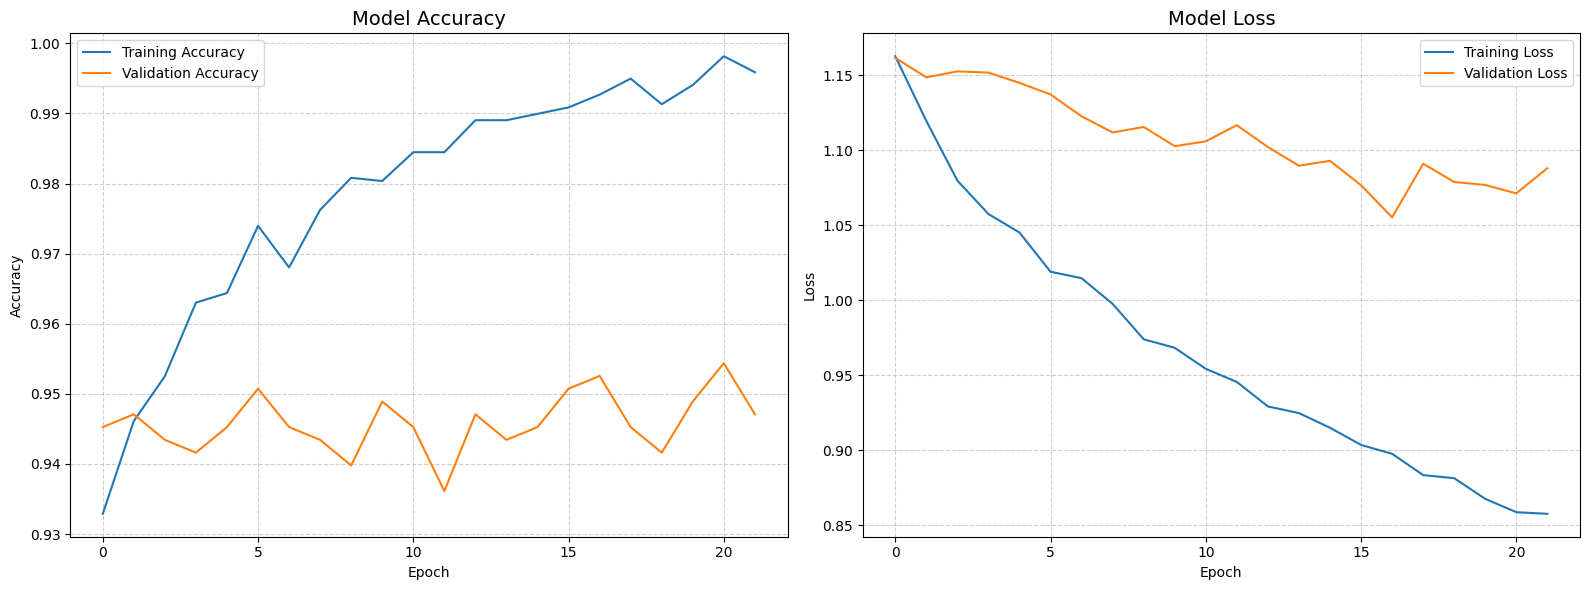

18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step


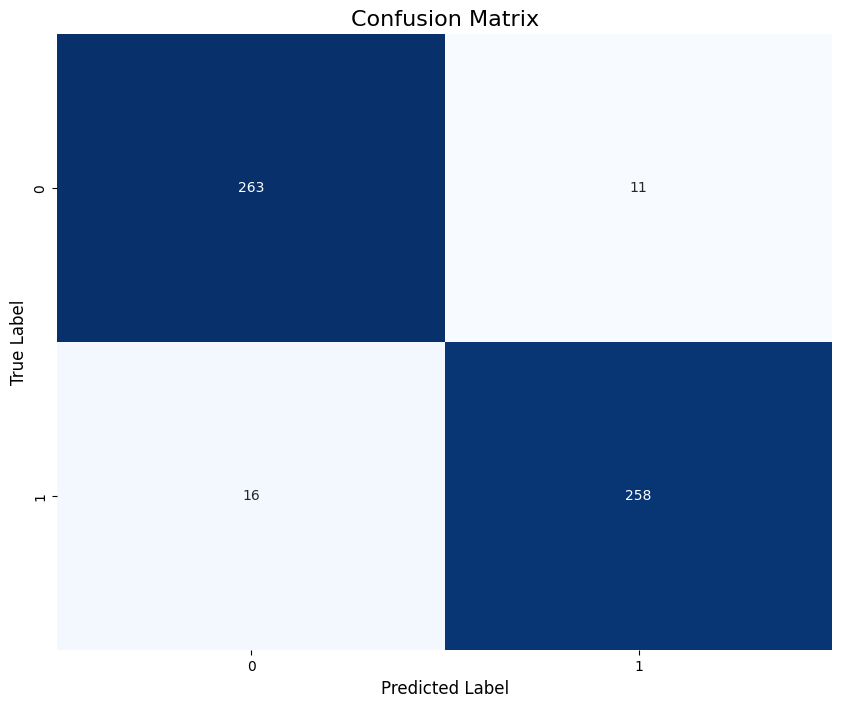


Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       274
           1       0.96      0.94      0.95       274

    accuracy                           0.95       548
   macro avg       0.95      0.95      0.95       548
weighted avg       0.95      0.95      0.95       548



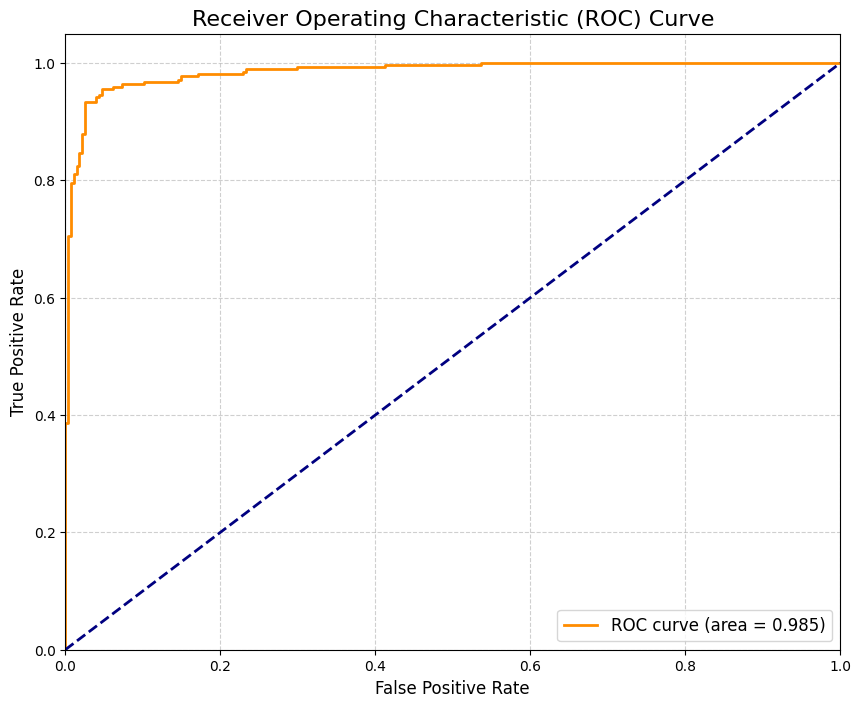

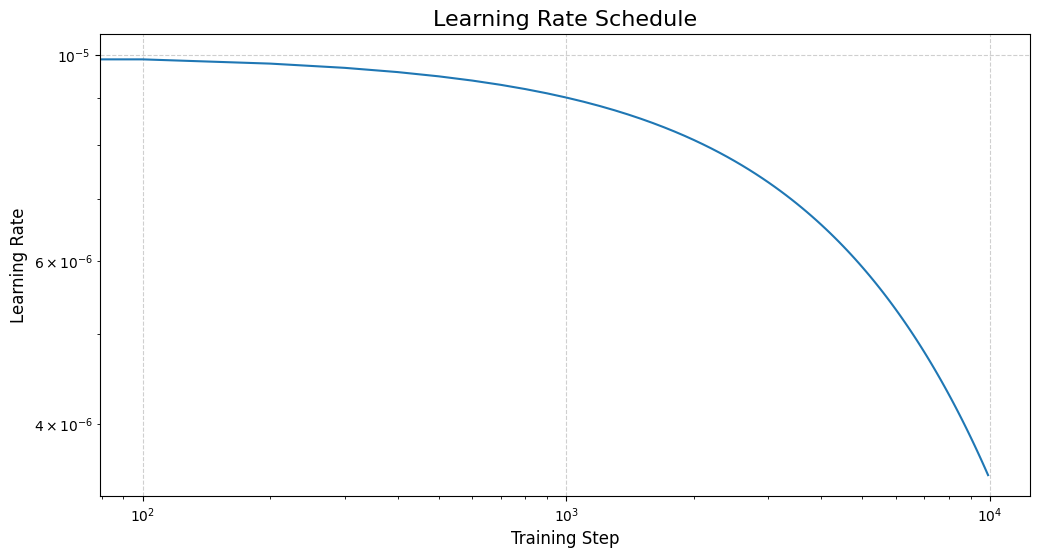

In [11]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc

# Plot training history
def plot_training_history(history):
    # Create figure with 2 subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Training Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy', fontsize=14)
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()
    ax1.grid(True, linestyle='--', alpha=0.6)
    
    # Plot loss
    ax2.plot(history.history['loss'], label='Training Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss', fontsize=14)
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()
    ax2.grid(True, linestyle='--', alpha=0.6)
    
    plt.tight_layout()
    plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

# Call this with your history object
plot_training_history(history)

# Generate predictions on validation set
# Assuming your val_dataset is a tf.data.Dataset
val_images_list = []
val_labels_list = []
for images, labels in val_dataset:
    if isinstance(images, tuple):  # If your dataset already returns a tuple of inputs
        val_images_list.append(images)
    else:  # If your dataset returns single images, create duplicate inputs
        val_images_list.append((images, images))
    val_labels_list.append(labels)

# Convert to appropriate format for prediction
val_images_resnet = []
val_images_efficientnet = []
for img_pair in val_images_list:
    val_images_resnet.append(img_pair[0])
    val_images_efficientnet.append(img_pair[1])

val_images_resnet = np.concatenate(val_images_resnet)
val_images_efficientnet = np.concatenate(val_images_efficientnet)
val_labels = np.concatenate(val_labels_list)

# Get predictions
y_pred_prob = model.predict([val_images_resnet, val_images_efficientnet])
y_pred = (y_pred_prob > 0.5).astype(int)

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title('Confusion Matrix', fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print classification report
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

plot_confusion_matrix(val_labels, y_pred)

# ROC Curve
def plot_roc_curve(y_true, y_pred_prob):
    fpr, tpr, _ = roc_curve(y_true, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.3f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
    plt.legend(loc='lower right', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('roc_curve.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_roc_curve(val_labels, y_pred_prob)

# Visualize model predictions
def visualize_predictions(images, true_labels, pred_probs, num_samples=10):
    indices = np.random.choice(range(len(images)), num_samples, replace=False)
    
    plt.figure(figsize=(20, 10))
    for i, idx in enumerate(indices):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[idx])
        pred_label = "Positive" if pred_probs[idx] > 0.5 else "Negative"
        true_label = "Positive" if true_labels[idx] == 1 else "Negative"
        color = "green" if pred_label == true_label else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label} ({pred_probs[idx][0]:.2f})", color=color)
        plt.axis('off')
    
    plt.tight_layout()
    plt.savefig('sample_predictions.png', dpi=300, bbox_inches='tight')
    plt.show()

# If you have raw images, you can visualize predictions
# First extract actual images from your validation dataset if available
# visualize_predictions(val_images_raw, val_labels, y_pred_prob)

# Learning rate visualization (if you used the schedule)
def plot_learning_rate():
    step_values = range(0, 10000, 100)
    lr_values = [lr_schedule(step).numpy() for step in step_values]
    
    plt.figure(figsize=(12, 6))
    plt.plot(step_values, lr_values)
    plt.title('Learning Rate Schedule', fontsize=16)
    plt.xlabel('Training Step', fontsize=12)
    plt.ylabel('Learning Rate', fontsize=12)
    plt.xscale('log')
    plt.yscale('log')
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.savefig('learning_rate_schedule.png', dpi=300, bbox_inches='tight')
    plt.show()

plot_learning_rate()

# Model Architecture Visualization (summary in a nicer format)
def simple_model_visualization(model):
    # Print the model summary
    model.summary()
    
    # Get layer types
    layer_types = [layer.__class__.__name__ for layer in model.layers]
    
    # Count occurrences of each layer type
    from collections import Counter
    type_counts = Counter(layer_types)
    
    # Plot the distribution
    plt.figure(figsize=(12, 6))
    plt.bar(type_counts.keys(), type_counts.values())
    plt.title('Distribution of Layer Types in Model', fontsize=16)
    plt.xlabel('Layer Type', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('model_layer_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Print summary statistics using built-in methods
    trainable_count = sum([tf.keras.backend.count_params(w) for w in model.trainable_weights])
    non_trainable_count = sum([tf.keras.backend.count_params(w) for w in model.non_trainable_weights])
    
    print(f"Total parameters: {trainable_count + non_trainable_count:,}")
    print(f"Trainable parameters: {trainable_count:,}")
    print(f"Non-trainable parameters: {non_trainable_count:,}")

In [ ]:
'''
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.models import load_model
import csv

# Load your trained model
model = load_model('/kaggle/working/lesion_detection7.keras')

# Path to test images folder on your local system
test_images_path = r'/kaggle/input/dr-testing-images/Testing'  # Adjust to your folder path

def preprocess_image(img_path):
    # Read and resize image
    image = cv2.imread(img_path)
    if image is None:
        print(f"Error reading {img_path}")
        return None, None

    image = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)

    # Convert to LAB and apply CLAHE to L-channel
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)

    # Get green channel and apply CLAHE
    green_channel = enhanced_image[:, :, 1]
    green_enhanced = clahe.apply(green_channel)

    # Background subtraction to enhance dark lesions
    blurred = cv2.GaussianBlur(green_enhanced, (9, 9), 0)
    subtracted = cv2.subtract(blurred, green_enhanced)

    # Morphological black-hat to further enhance dark blobs (red lesions)
    blackhat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (15, 15))
    black_hat = cv2.morphologyEx(green_enhanced, cv2.MORPH_BLACKHAT, blackhat_kernel)

    # Exudate suppression using top-hat
    tophat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))
    tophat = cv2.morphologyEx(green_enhanced, cv2.MORPH_TOPHAT, tophat_kernel)

    # Combine subtraction and black-hat
    combined = cv2.addWeighted(subtracted, 0.5, black_hat, 0.5, 0)

    # Suppress exudates
    cleaned = cv2.subtract(combined, tophat)

    # Normalize and apply light gamma correction
    normalized = cv2.normalize(cleaned, None, 0, 255, cv2.NORM_MINMAX)
    gamma = 0.9
    lut = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(normalized.astype(np.uint8), lut)

    # Convert to 3-channel grayscale
    final_3channel = cv2.merge([gamma_corrected] * 3)
    final_3channel = cv2.resize(final_3channel, (224, 224))
    

    # TensorFlow-style data augmentation (same as used during training)
    img_resnet = tf.convert_to_tensor(final_3channel)
    img_efficientnet = tf.convert_to_tensor(final_3channel)

    img_resnet = tf.image.random_flip_left_right(img_resnet)
    img_resnet = tf.image.random_brightness(img_resnet, max_delta=0.2)
    img_resnet = tf.image.random_contrast(img_resnet, lower=0.8, upper=1.2)

    img_efficientnet = tf.image.random_flip_left_right(img_efficientnet)
    img_efficientnet = tf.image.random_saturation(img_efficientnet, lower=0.7, upper=1.3)
    img_efficientnet = tf.image.random_hue(img_efficientnet, max_delta=0.1)

    img_resnet = tf.expand_dims(img_resnet, axis=0)
    img_efficientnet = tf.expand_dims(img_efficientnet, axis=0)

    img_resnet = tf.keras.applications.resnet50.preprocess_input(img_resnet)
    img_efficientnet = tf.keras.applications.efficientnet.preprocess_input(img_efficientnet)


    return img_resnet, img_efficientnet

# List to store results
results = []

# Iterate through images in the folder
for img_name in os.listdir(test_images_path):
    img_path = os.path.join(test_images_path, img_name)

    # Ensure it's a file (not a subfolder)
    if os.path.isfile(img_path):
        preprocessed_img = preprocess_image(img_path)

        # Predict using the model
        prediction = model.predict(preprocessed_img)[0][0]  # Get the prediction score
        print(prediction)

        # Classification logic: 0 = AI, 1 = Human
        label = 'Red_Lesions' if prediction > 0.5 else 'No_DR'
        results.append((img_name, label))

# Save results to a CSV file
output_file = r'1st.csv'  # Adjust to desired output path

with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Classification'])  # Write header
    writer.writerows(results)  # Write image classification results

print(f"Results saved to {output_file}")
'''

In [ ]:
'''
#New testing code ----------------------------------------------------------------------------Latest
import cv2
import numpy as np
import os
import tensorflow as tf
from tensorflow.keras.models import load_model
import csv
from tqdm import tqdm

# Load your trained model
model = load_model('/kaggle/working/lesion_detection5.keras')

# Path to test images folder 
test_images_path = r'/kaggle/input/dr-testing-images/Testing'  # Adjust to your folder path

def is_dark_patch(patch, r_patch, b_patch, threshold=45, dark_ratio=0.4):
    """Check if a patch is likely a red lesion by color and darkness criteria"""
    # Color ratio check (red lesions have specific R:G:B ratios)
    avg_r = np.mean(r_patch)
    avg_g = np.mean(patch)  # green channel
    avg_b = np.mean(b_patch)

    # For true red lesions, green channel is darker than blue
    g_b_ratio = (avg_b + 1) / (avg_g + 1)
    # And red channel is brighter than green for hemorrhages
    r_g_ratio = (avg_r + 1) / (avg_g + 1)
    
    color_check = (g_b_ratio > 1.05) and (r_g_ratio > 1.1)

    # Relaxed parameters to detect more potential lesions
    dark_pixels = np.sum(patch < threshold)
    total_pixels = patch.size
    darkness_check = (dark_pixels / total_pixels) > dark_ratio
    
    return darkness_check and color_check

def adaptive_threshold_retina(image):
    """Create better retina mask using adaptive methods"""
    # Convert to grayscale if not already
    if len(image.shape) > 2:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image
        
    # Use adaptive thresholding for better segmentation
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    _, mask = cv2.threshold(blurred, 15, 255, cv2.THRESH_BINARY)
    
    # Clean up the mask with morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    # Create a more defined circular mask
    h, w = mask.shape
    center = (w // 2, h // 2)
    radius = min(h, w) // 2 - 10  # Slight margin from the edge
    
    circle_mask = np.zeros_like(mask)
    cv2.circle(circle_mask, center, radius, 255, -1)
    
    # Combine both masks
    final_mask = cv2.bitwise_and(mask, circle_mask)
    
    return final_mask

def multi_scale_patch_highlight(image, retina_mask):
    """Multi-scale approach to detect lesions of various sizes"""
    green = image[:, :, 1]  # Green channel has best contrast for lesions
    height, width = green.shape
    result_mask = np.zeros_like(green, dtype=np.uint8)
    
    # Multi-scale approach with different patch sizes
    patch_sizes = [7, 11, 15]  # Multiple scales to catch different sized lesions
    
    for patch_size in patch_sizes:
        temp_mask = np.zeros_like(green, dtype=np.uint8)
        
        for y in range(0, height, patch_size // 2):  # Overlapping patches for better coverage
            for x in range(0, width, patch_size // 2):
                # Check if patch is within bounds
                if y + patch_size > height or x + patch_size > width:
                    continue
                
                # Skip if patch is mostly outside the retina
                roi = retina_mask[y:y+patch_size, x:x+patch_size]
                if np.sum(roi > 0) / roi.size < 0.8:
                    continue
                
                patch = green[y:y+patch_size, x:x+patch_size]
                r_patch = image[y:y+patch_size, x:x+patch_size, 2]  # Red channel
                b_patch = image[y:y+patch_size, x:x+patch_size, 0]  # Blue channel
                
                # Check if it's a potential lesion (dark patch)
                if is_dark_patch(patch, r_patch, b_patch, threshold=45 if patch_size < 10 else 50):
                    # More permissive vessel filtering: check for elongated structures
                    # rather than just counting dark neighbors
                    is_vessel = False
                    
                    # For vessel detection, use directional checking instead of just neighbors
                    h_profile = np.mean(patch, axis=0)  # Horizontal profile
                    v_profile = np.mean(patch, axis=1)  # Vertical profile
                    
                    h_std = np.std(h_profile)
                    v_std = np.std(v_profile)
                    
                    # Vessels tend to have higher variance in one direction
                    if max(h_std, v_std) / (min(h_std, v_std) + 1e-6) > 3.0:
                        is_vessel = True
                        
                    if not is_vessel:
                        temp_mask[y:y+patch_size, x:x+patch_size] = 255
        
        # Add to result with different weights based on scale
        weight = 0.5 if patch_size == 7 else (0.7 if patch_size == 11 else 1.0)
        result_mask = cv2.bitwise_or(result_mask, (temp_mask * weight).astype(np.uint8))
    
    return result_mask

def enhance_green_channel(image):
    """Enhanced green channel processing specifically for red lesions"""
    # Split channels
    b, g, r = cv2.split(image)
    
    # Apply CLAHE to green channel
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    g_enhanced = clahe.apply(g)
    
    # Contrast stretching for better lesion visibility
    p5 = np.percentile(g_enhanced, 5)
    p95 = np.percentile(g_enhanced, 95)
    if p95 == p5:
        g_stretched = np.clip(g_enhanced, 0, 255).astype(np.uint8)
    else:
        g_stretched = np.clip((g_enhanced - p5) * 255.0 / (p95 - p5), 0, 255).astype(np.uint8)
    
    # Calculate inverted red to enhance red lesions (which appear dark in green channel)
    inverted_r = cv2.bitwise_not(r)
    
    # Combine green and inverted red (weighted)
    enhanced = cv2.addWeighted(g_stretched, 0.8, inverted_r, 0.2, 0)
    
    return enhanced

def process_image_for_prediction(image_path, resize_dim=(224, 224)):
    """
    Process an image using the same pipeline as in training,
    and prepare it for model prediction
    """
    # Load the image
    image = cv2.imread(image_path)
    if image is None:
        print(f"Error: Unable to read {image_path}")
        return None

    # Resize to standard dimensions
    image = cv2.resize(image, resize_dim, interpolation=cv2.INTER_AREA)

    # Create retina mask
    retina_mask = adaptive_threshold_retina(image)

    # Convert to LAB and apply CLAHE to L-channel (enhanced contrast)
    lab = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    enhanced_lab = cv2.merge((l, a, b))
    enhanced_image = cv2.cvtColor(enhanced_lab, cv2.COLOR_LAB2BGR)
    
    # Enhanced green channel processing
    green_enhanced = enhance_green_channel(enhanced_image)

    clahe_local = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(4, 4))
    green_local = clahe_local.apply(enhanced_image[:,:,1])
    enhanced_image[:,:,1] = green_local
    
    # Use multi-scale approach for better lesion detection
    red_lesion_mask = multi_scale_patch_highlight(enhanced_image, retina_mask)

    # Filter out large connected components (likely vessels)
    num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(red_lesion_mask, connectivity=8)
    filtered_mask = np.zeros_like(red_lesion_mask)
    
    for i in range(1, num_labels):  # Skip background (0)
        area = stats[i, cv2.CC_STAT_AREA]
        width = stats[i, cv2.CC_STAT_WIDTH]
        height = stats[i, cv2.CC_STAT_HEIGHT]
        
        # Keep only components that aren't too large or elongated
        if area < 300 and max(width, height) / min(width, height) < 3:
            filtered_mask[labels == i] = 255
    
    red_lesion_mask = filtered_mask

    # Apply the red lesion mask to focus on potential lesions
    lesion_region = cv2.bitwise_and(green_enhanced, red_lesion_mask)

    # Post-processing to enhance lesions
    # Gaussian blur to smooth the enhanced regions
    blurred = cv2.GaussianBlur(lesion_region, (7, 7), 0)
    
    # Subtract to enhance edges (modified to avoid over-subtraction)
    subtracted = cv2.addWeighted(blurred, 1.2, lesion_region, -0.8, 0)
    subtracted = cv2.normalize(subtracted, None, 0, 255, cv2.NORM_MINMAX)

    # Morphological operations to enhance lesion structures
    blackhat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    black_hat = cv2.morphologyEx(lesion_region, cv2.MORPH_BLACKHAT, blackhat_kernel)
    black_hat = cv2.normalize(black_hat, None, 0, 255, cv2.NORM_MINMAX)

    tophat_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (11, 11))
    tophat = cv2.morphologyEx(lesion_region, cv2.MORPH_TOPHAT, tophat_kernel)
    tophat = cv2.normalize(tophat, None, 0, 100, cv2.NORM_MINMAX)  # Reduced effect of tophat

    # Combine different enhancements with adjusted weights
    combined = cv2.addWeighted(subtracted, 0.7, black_hat, 0.5, 0)
    cleaned = cv2.subtract(combined, tophat)

    # Final normalization and gamma correction
    normalized = cv2.normalize(cleaned, None, 0, 255, cv2.NORM_MINMAX)
    gamma = 0.85  # Slightly increased gamma for better contrast
    lut = np.array([((i / 255.0) ** gamma) * 255 for i in range(256)]).astype("uint8")
    gamma_corrected = cv2.LUT(normalized.astype(np.uint8), lut)

    # Create final 3-channel image
    final_3channel = cv2.merge([gamma_corrected] * 3)
    final_3channel = cv2.resize(final_3channel, resize_dim)
    
    # Convert to TF tensor
    image_tensor = tf.convert_to_tensor(final_3channel)
    
    # Create copies for both model branches
    resnet_image = tf.identity(image_tensor)
    efficientnet_image = tf.identity(image_tensor)
    
    # For testing we don't need augmentation, we want consistent results
    # Convert to model input format
    resnet_image = tf.expand_dims(resnet_image, axis=0)
    efficientnet_image = tf.expand_dims(efficientnet_image, axis=0)
    
    # Apply appropriate preprocessing for each model
    resnet_image = tf.keras.applications.resnet50.preprocess_input(resnet_image)
    efficientnet_image = tf.keras.applications.efficientnet.preprocess_input(efficientnet_image)
    
    return (resnet_image, efficientnet_image)

# Process all images in the test folder
results = []
print(f"Processing images from {test_images_path}...")

# Create output directory if needed
os.makedirs('/kaggle/working/results', exist_ok=True)

# Process each test image
for img_name in tqdm(os.listdir(test_images_path)):
    img_path = os.path.join(test_images_path, img_name)
    
    # Skip non-image files
    if not img_path.lower().endswith(('.png', '.jpg', '.jpeg')):
        continue
        
    # Ensure it's a file (not a subfolder)
    if os.path.isfile(img_path):
        try:
            # Get preprocessed image inputs
            model_inputs = process_image_for_prediction(img_path)
            
            if model_inputs is None:
                print(f"Failed to process {img_name}")
                results.append((img_name, "Error", -1))
                continue
                
            # Make prediction with the model
            prediction = model.predict(model_inputs, verbose=0)[0][0]  # Get the prediction score
            
            # Classification logic: 0 = No_DR, 1 = Red_Lesions
            label = 'Red_Lesions' if prediction > 0.5 else 'No_DR'
            
            # Add to results list
            results.append((img_name, label, float(prediction)))
            
        except Exception as e:
            print(f"Error processing {img_name}: {e}")
            results.append((img_name, "Error", -1))

# Save detailed results to a CSV file
output_file = '/kaggle/working/dr_predictions.csv'

with open(output_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Image Name', 'Classification', 'Prediction Score'])  # Write header
    writer.writerows(results)  # Write image classification results

print(f"Results saved to {output_file}")

# Create a simplified submission file if needed
submission_file = '/kaggle/working/submission.csv'
with open(submission_file, mode='w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['image', 'diagnosis'])  # Adjust header as needed for your competition
    for img_name, label, _ in results:
        if label != "Error":
            writer.writerow([img_name, label])

print(f"Submission file saved to {submission_file}")
'''

In [ ]:
'''
import pandas as pd

# Load the CSV file
file_path = "/kaggle/working/1st.csv"  # Change this to your actual file path
df = pd.read_csv(file_path)

# Ensure required columns exist
if "Image Name" in df.columns and "Classification" in df.columns:
    # Sort by 'Image Name' alphabetically
    df = df.sort_values(by="Image Name")

    # Display the sorted CSV content
    print("CSV File Contents (Sorted Alphabetically by Image Name):")
    print(df)

    # Function to check correctness
    def is_correct(row):
        if row["Image Name"].startswith("No_DR") and row["Classification"] == "No_DR":
            return True
        elif row["Image Name"].startswith("Red_Lesions") and row["Classification"] == "Red_Lesions":
            return True
        return False

    # Apply function to each row
    df["Correct"] = df.apply(is_correct, axis=1)

    # Calculate accuracy
    correct_predictions = df["Correct"].sum()
    total_predictions = len(df)
    accuracy = (correct_predictions / total_predictions) * 100

    print("\nModel Accuracy: {:.2f}%".format(accuracy))
else:
    print("\nError: The CSV file must contain 'Image Name' and 'Classification' columns.")
'''

In [ ]:
'''
import shutil
import os

# Define the folder you want to download
folder_path = "/kaggle/working/DR_OD_Removed_100/removed_od"
zip_path = "/kaggle/working/DR_OD_Removed200.zip"


# Zip the folder
shutil.make_archive(zip_path.replace(".zip", ""), 'zip', folder_path)

# Download the ZIP file
from IPython.display import FileLink
FileLink(zip_path)
'''

In [ ]:
'''
import os
import zipfile
import glob
from tqdm.notebook import tqdm
import math

def split_zip_folder(source_dir, output_prefix, max_size_gb=2.0, ignore_patterns=None):
    """
    Create multiple zip files from a directory, each with a maximum size.
    
    Args:
        source_dir (str): Directory to zip
        output_prefix (str): Prefix for output zip filenames (without .zip extension)
        max_size_gb (float): Maximum size of each zip file in GB
        ignore_patterns (list): List of glob patterns to ignore
    
    Returns:
        list: List of created zip filenames
    """
    # Convert max size to bytes
    max_size_bytes = max_size_gb * 1024 * 1024 * 1024
    
    # Get list of files to zip with their sizes
    all_files = []
    for root, _, files in os.walk(source_dir):
        for file in files:
            file_path = os.path.join(root, file)
            # Skip if it's a zip file with our prefix
            if file_path.startswith(output_prefix) and file_path.endswith('.zip'):
                continue
            # Apply ignore patterns if specified
            if ignore_patterns and any(glob.fnmatch.fnmatch(file_path, pattern) for pattern in ignore_patterns):
                continue
            file_size = os.path.getsize(file_path)
            all_files.append((file_path, file_size))
    
    # Calculate total size for information
    total_size = sum(size for _, size in all_files)
    print(f"Total size to zip: {total_size / (1024*1024*1024):.2f} GB")
    print(f"Number of files: {len(all_files)}")
    
    # Sort files by size (largest first) to optimize packing
    all_files.sort(key=lambda x: x[1], reverse=True)
    
    # Initialize counters and storage for created files
    current_zip_size = 0
    current_zip_number = 1
    created_zip_files = []
    
    # Create zip files
    current_zip_name = f"{output_prefix}_part{current_zip_number}.zip"
    current_zipfile = zipfile.ZipFile(current_zip_name, 'w', zipfile.ZIP_DEFLATED)
    
    with tqdm(total=total_size, unit='B', unit_scale=True, desc="Zipping") as pbar:
        for file_path, file_size in all_files:
            # If this file would push us over the limit, close current zip and start a new one
            # Exception: if the file is the first one in a new zip
            if current_zip_size > 0 and current_zip_size + file_size > max_size_bytes:
                current_zipfile.close()
                created_zip_files.append(current_zip_name)
                print(f"Created {current_zip_name} ({current_zip_size / (1024*1024*1024):.2f} GB)")
                
                # Start a new zip file
                current_zip_number += 1
                current_zip_name = f"{output_prefix}_part{current_zip_number}.zip"
                current_zipfile = zipfile.ZipFile(current_zip_name, 'w', zipfile.ZIP_DEFLATED)
                current_zip_size = 0
            
            # Add file to current zip
            rel_path = os.path.relpath(file_path, source_dir)
            current_zipfile.write(file_path, rel_path)
            current_zip_size += file_size
            pbar.update(file_size)
    
    # Close the last zip file
    current_zipfile.close()
    created_zip_files.append(current_zip_name)
    print(f"Created {current_zip_name} ({current_zip_size / (1024*1024*1024):.2f} GB)")
    
    return created_zip_files

# Define the folder you want to download
folder_path = "/kaggle/working/DR_OD_Removed_100/removed_od"
output_prefix = "/kaggle/working/DR_OD_Removed100"

# Optional: Define patterns to ignore
ignore_patterns = None

# Set maximum size per zip file (in GB)
max_size_gb = 2.0

# Zip the folder with splitting
zip_files = split_zip_folder(folder_path, output_prefix, max_size_gb, ignore_patterns)

print("\nDownload Instructions:")
print("1. Look for the 'Output' tab in the right sidebar of your Kaggle notebook")
print("2. Click on the download icon next to each zip file to download it")
print("3. After downloading all parts, you can recombine them if needed")
'''

In [2]:
'''
#NOTE: Deletes all the output file so use with caution


!rm -rf /kaggle/working/*
'''

In [ ]:
'''
from IPython.display import FileLink

# Path to your zip file
zip_file_path = "/kaggle/working/DR_OD_Removed100_part1.zip"

# Display the download link
FileLink(zip_file_path)
'''